<a href="https://colab.research.google.com/github/RodMendez/Estad-stica/blob/main/An%C3%A1lisis_exploratorio_y_red_neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


In [ ]:
data = pd.read_csv("Mayor R .csv")

In [ ]:
print(data.columns)

Index(['Nombre', 'Rmax rayos X', 'nelec', 'Tx', 'S', 'σLOS', 'Rvir', 'Mvir',
       'A', 'Hz'],
      dtype='object')


In [ ]:
# Importar librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2  #para evitar el sobreajuste

In [ ]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(data.describe())


Estadísticas descriptivas:
       Rmax rayos X      nelec         Tx            S         σLOS  \
count     38.000000  38.000000  38.000000    38.000000    38.000000   
mean       0.417516   0.005949   5.049737   337.831579   830.421053   
std        0.628878   0.016627   2.150062   261.709357   196.758135   
min        0.056100   0.000709   1.620000    60.600000   343.000000   
25%        0.184000   0.001375   3.792500   171.000000   714.750000   
50%        0.291500   0.002255   4.980000   228.000000   818.500000   
75%        0.474250   0.003893   6.005000   395.750000   988.750000   
max        4.000000   0.104000  10.900000  1060.000000  1222.000000   

            Rvir       Mvir         Hz  
count  38.000000  38.000000  38.000000  
mean    2.014289   9.902632  15.632895  
std     0.433730   5.542479   0.685368  
min     0.870000   0.680000  13.470000  
25%     1.812250   6.212500  15.347500  
50%     1.990500   8.405000  15.675000  
75%     2.363500  13.975000  16.160000  
max 


Distribución de variables numéricas:


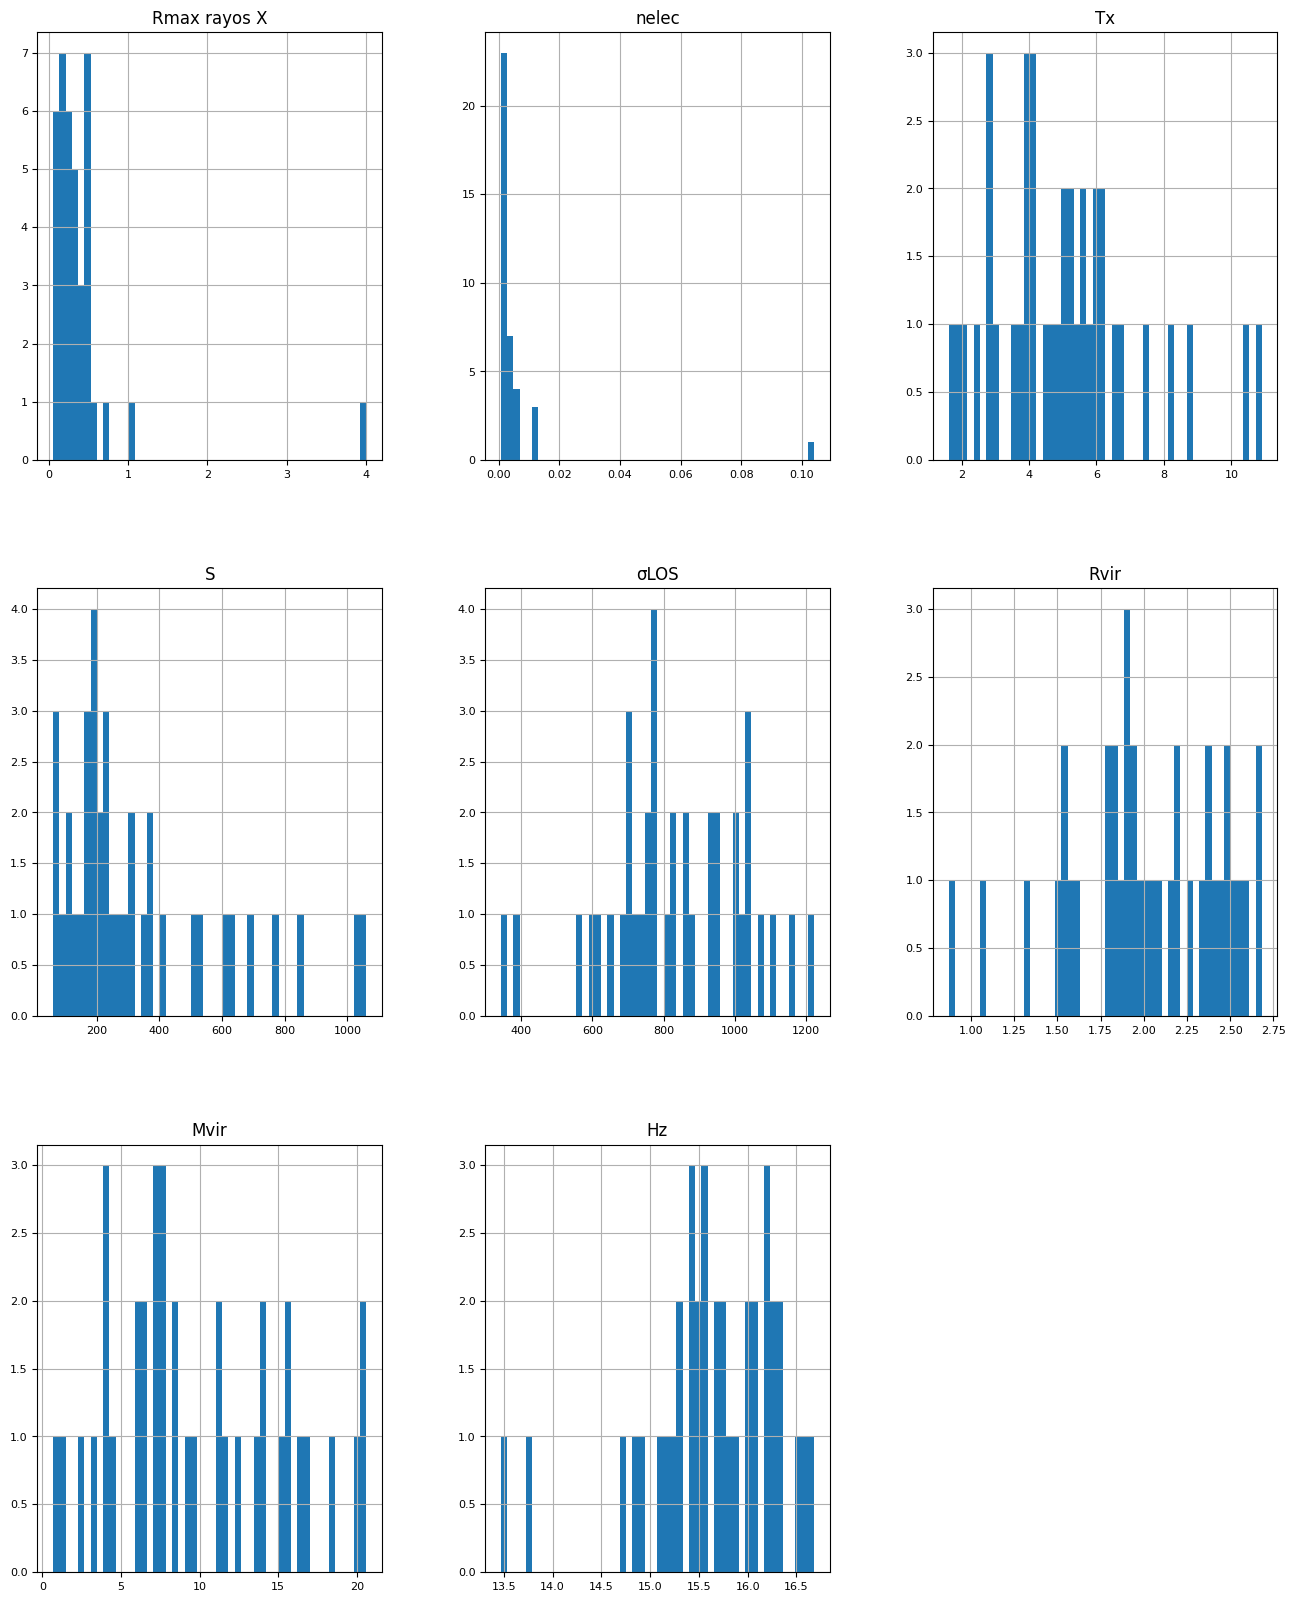

In [ ]:
# Distribución de cada variable
print("\nDistribución de variables numéricas:")
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [ ]:
# Convertir las columnas relevantes a tipo numérico
numeric_columns = data.columns.drop(['Nombre', 'A'])  # Excluimos 'Name' de la conversión numérica
data_numeric = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Calcular el rango intercuartílico (IQR) para cada columna numérica
Q1 = data_numeric.quantile(0.25)
Q3 = data_numeric.quantile(0.75)
IQR = Q3 - Q1

# Definir un umbral para identificar outliers
threshold = 2.5

# Función para identificar outliers en una fila
def identify_outliers(row):
    outliers = []
    for col in data_numeric.columns:
        if row[col] < (Q1[col] - threshold * IQR[col]) or row[col] > (Q3[col] + threshold * IQR[col]):
            outliers.append(col)
    return outliers if outliers else np.nan

# Aplicar la función a cada fila y crear una nueva columna con la lista de variables outlier
data['outlier_vars'] = data_numeric.apply(identify_outliers, axis=1)

# Filtrar solo las filas que contienen outliers
outliers_data = data[data['outlier_vars'].notna()]

# Imprimir los resultados
for _, row in outliers_data.iterrows():
    print(f"Cúmulo: {row['Nombre']}")
    print(f"Variables outlier: {', '.join(row['outlier_vars'])}")
    print("Valores:")
    for var in row['outlier_vars']:
        print(f"  {var}: {row[var]}")
    print("\n")


Cúmulo: ABELL_0401
Variables outlier: S
Valores:
  S: 1040.0


Cúmulo: ABELL_0426                
Variables outlier: nelec
Valores:
  nelec: 0.0127


Cúmulo: ABELL_1060                
Variables outlier: nelec
Valores:
  nelec: 0.0128


Cúmulo: ABELL_2029                
Variables outlier: S
Valores:
  S: 1060.0


Cúmulo: ABELL_2199                
Variables outlier: nelec
Valores:
  nelec: 0.104


Cúmulo: ABELL_3526A
Variables outlier: Rmax rayos X, nelec
Valores:
  Rmax rayos X: 4.0
  nelec: 0.0116




In [ ]:
# Crear DataFrame limpio sin outliers
clean_df = data[data['outlier_vars'].isna()].drop(columns=['outlier_vars'])



Matriz de correlación:


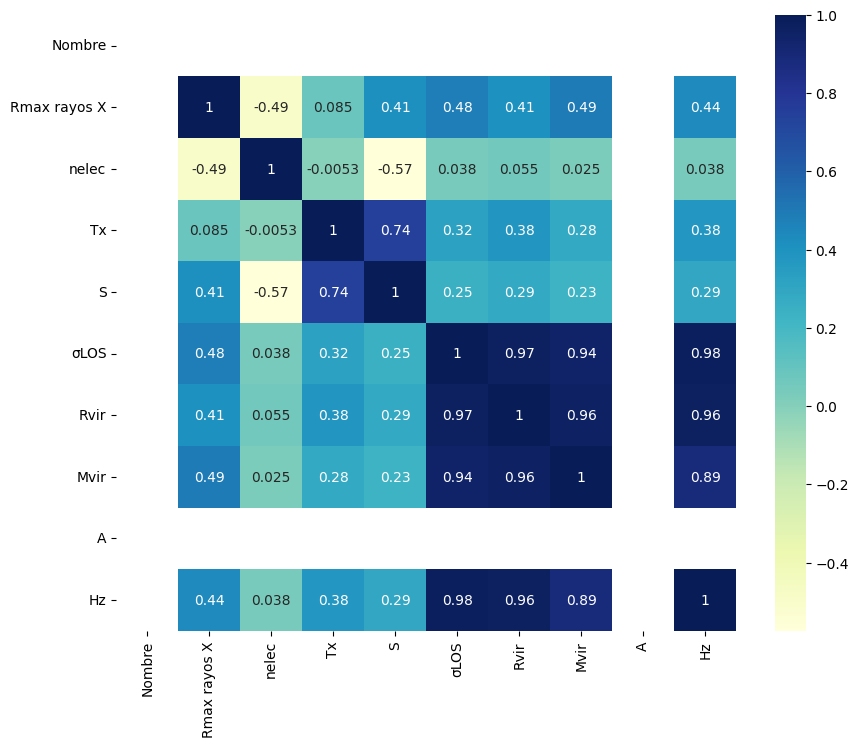

In [ ]:
# Convertir las columnas relevantes a tipo numérico
clean_df_numeric = clean_df.apply(pd.to_numeric, errors='coerce')

# Matriz de correlación
print("\nMatriz de correlación:")
plt.figure(figsize=(10, 8))
sns.heatmap(clean_df_numeric.corr(), annot=True, cmap="YlGnBu")
plt.show()

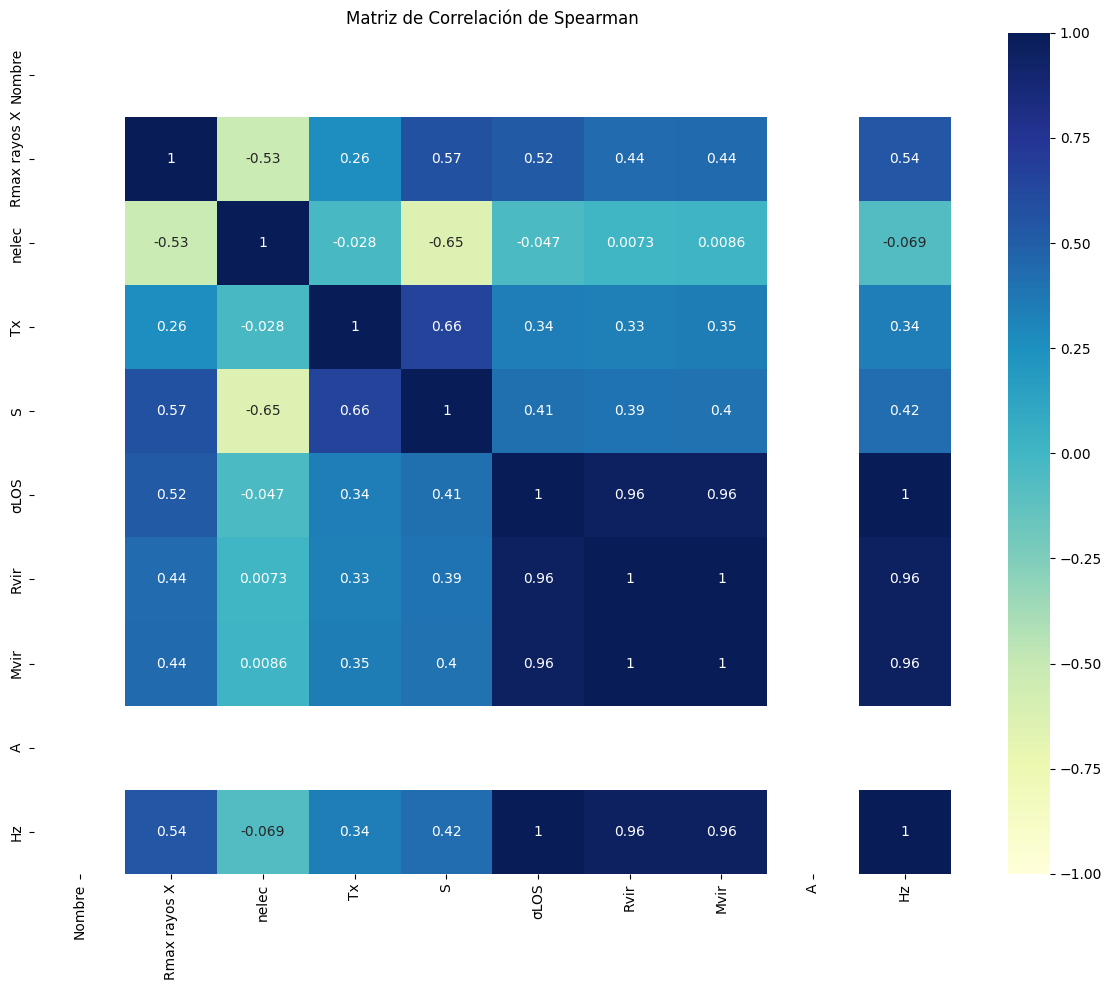

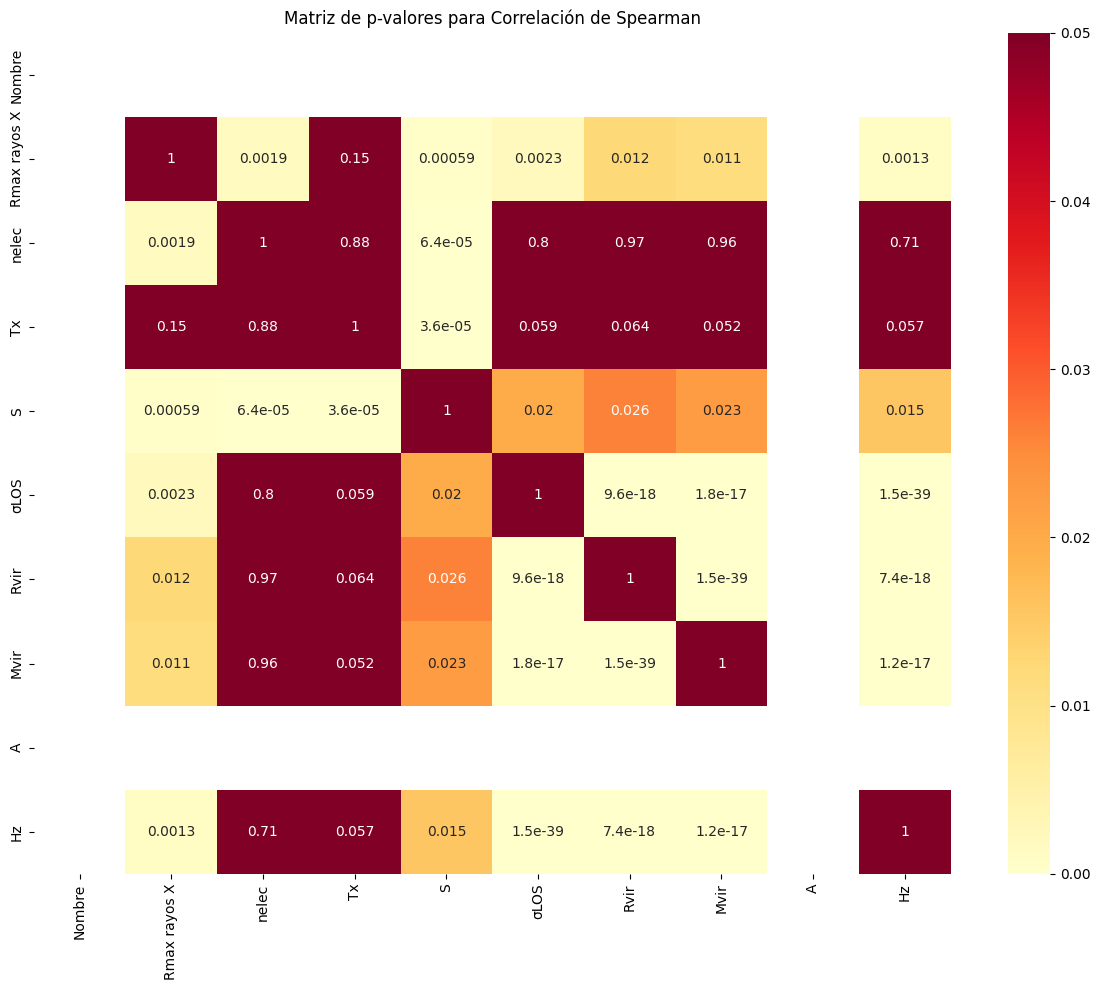


Correlaciones de Spearman significativas (p < 0.05):
nelec vs Rmax rayos X: correlación = -0.528, p-valor = 0.0019
S vs Rmax rayos X: correlación = 0.574, p-valor = 0.0006
S vs nelec: correlación = -0.647, p-valor = 0.0001
S vs Tx: correlación = 0.663, p-valor = 0.0000
σLOS vs Rmax rayos X: correlación = 0.519, p-valor = 0.0023
σLOS vs S: correlación = 0.409, p-valor = 0.0199
Rvir vs Rmax rayos X: correlación = 0.437, p-valor = 0.0124
Rvir vs S: correlación = 0.393, p-valor = 0.0261
Rvir vs σLOS: correlación = 0.957, p-valor = 0.0000
Mvir vs Rmax rayos X: correlación = 0.442, p-valor = 0.0113
Mvir vs S: correlación = 0.402, p-valor = 0.0225
Mvir vs σLOS: correlación = 0.956, p-valor = 0.0000
Mvir vs Rvir: correlación = 0.999, p-valor = 0.0000
Hz vs Rmax rayos X: correlación = 0.543, p-valor = 0.0013
Hz vs S: correlación = 0.425, p-valor = 0.0154
Hz vs σLOS: correlación = 0.999, p-valor = 0.0000
Hz vs Rvir: correlación = 0.958, p-valor = 0.0000
Hz vs Mvir: correlación = 0.957, p-valor 

In [ ]:
from scipy import stats


# Convertir las columnas relevantes a tipo numérico
clean_df_numeric = clean_df.apply(pd.to_numeric, errors='coerce')

# Calcular la matriz de correlación de Spearman
correlation_matrix = clean_df_numeric.corr(method='spearman')

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", vmin=-1, vmax=1, center=0)
plt.title("Matriz de Correlación de Spearman")
plt.tight_layout()
plt.show()

# Función para calcular el p-valor para la correlación de Spearman
def spearman_pvalue(x, y):
    return stats.spearmanr(x, y)[1]

# Calcular matriz de p-valores
p_value_matrix = clean_df_numeric.corr(method=spearman_pvalue)

# Visualizar la matriz de p-valores
plt.figure(figsize=(12, 10))
sns.heatmap(p_value_matrix, annot=True, cmap="YlOrRd", vmin=0, vmax=0.05)
plt.title("Matriz de p-valores para Correlación de Spearman")
plt.tight_layout()
plt.show()

# Imprimir correlaciones significativas
print("\nCorrelaciones de Spearman significativas (p < 0.05):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if p_value_matrix.iloc[i, j] < 0.05:
            print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: "
                  f"correlación = {correlation_matrix.iloc[i, j]:.3f}, "
                  f"p-valor = {p_value_matrix.iloc[i, j]:.4f}")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

X = clean_df.drop(['Nombre', 'A', 'Hz', 'Rmax rayos X', 'nelec', 'Tx', 'S'], axis=1)  # Entradas
y = clean_df['Hz']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Construir el modelo
model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(50, activation='relu'),
    Dense(1, activation='linear'),                                          #capa de salida
])


# Construir el modelo sin regularización L2
#model = Sequential([
    #Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
  #  Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
   # Dense(1, activation='linear')])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,  # Aumentamos el número máximo de épocas
    batch_size=5,  # Reducimos el tamaño del batch
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar el modelo
val_loss = model.evaluate(X_val_scaled, y_val, verbose=0)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 234.9484 - val_loss: 200.8708
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 173.8280 - val_loss: 127.2575
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 96.1879 - val_loss: 50.0550
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55.3386 - val_loss: 54.3158
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 53.4364 - val_loss: 40.7228
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27.2774 - val_loss: 28.4647
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.3866 - val_loss: 22.0659
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20.1580 - val_loss: 8.8978
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7091 - val_loss: 4.0961
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9860 - val_loss: 4.1665
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6936 - val_loss: 1.5504
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6765 - val_loss: 

Train Loss: 0.02681349776685238
Validation Loss: 0.08134593069553375


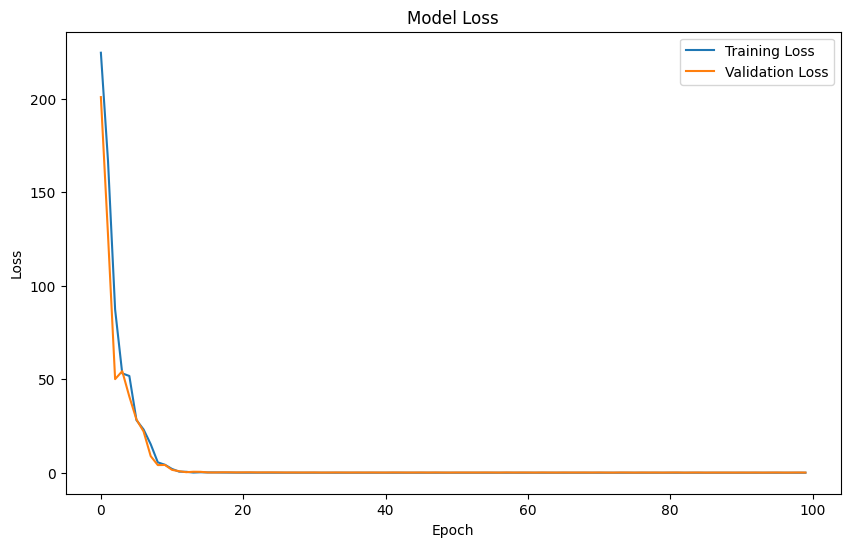

In [ ]:
# Evaluar el modelo
train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
val_loss = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

# Visualizar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Mean Squared Error: 0.21446862742636205
Root Mean Squared Error: 0.46310757651582646
R-squared: 0.6122139880789108


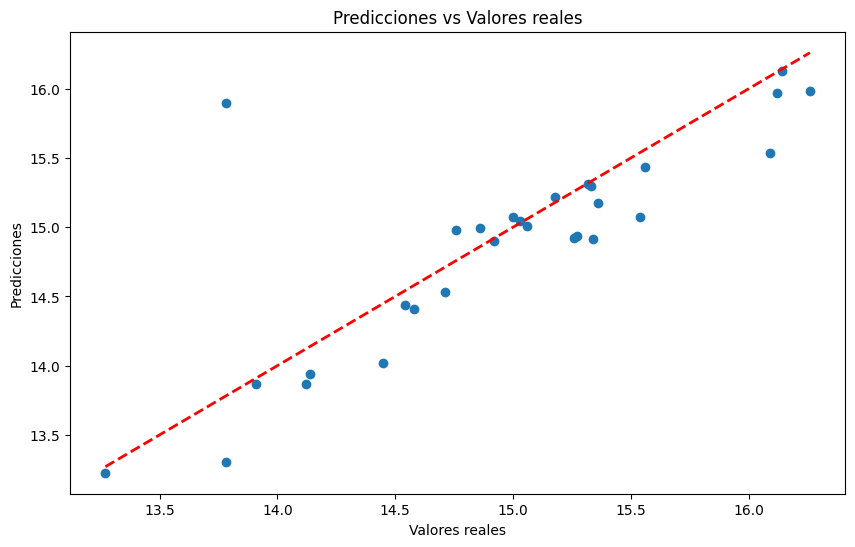

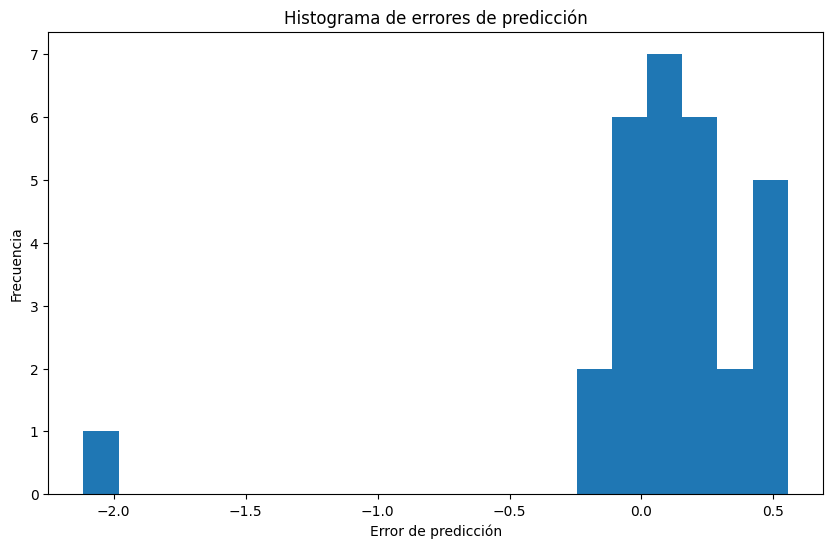

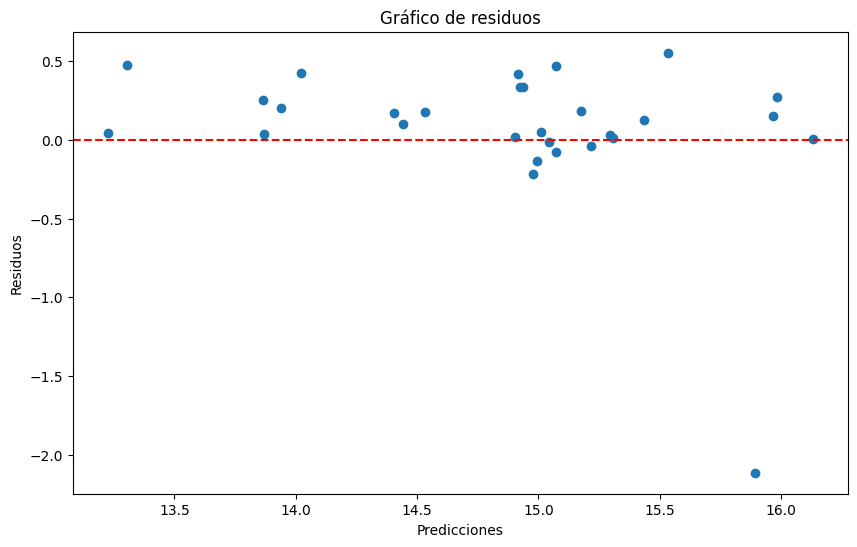

In [ ]:
# Cargar el dataset de prueba
test_data = pd.read_csv("Top70 optico test (sin L).csv", usecols=['Name', '?LOS', 'Rvir', 'Mvir', 'Hz', 'A'])

# Renombrar la columna
test_data.rename(columns={'?LOS': 'σLOS'}, inplace=True)

# Continuar con el resto del código
X_test = test_data.drop(['Name', 'A', 'Hz'], axis=1)
y_test = test_data['Hz']

# Normalizar los datos de prueba usando el mismo scaler que para los datos de entrenamiento
X_test_scaled = scaler.transform(X_test)

# Hacer predicciones
y_pred = model.predict(X_test_scaled)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales')
plt.show()

# Histograma de errores de predicción
errors = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20)
plt.xlabel('Error de predicción')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores de predicción')
plt.show()

# Gráfico de residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, errors)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


In [ ]:
# Calcular errores
errors = y_test - y_pred.flatten()

# Agregar errores al conjunto de datos de prueba
test_data['Predicciones'] = y_pred.flatten()
test_data['Errores'] = errors

# Mostrar cúmulos con errores significativos
threshold = 0.5  # Define un umbral que consideres significativo
significant_errors = test_data[abs(test_data['Errores']) > threshold]
print(significant_errors[['Name', 'Hz', 'Predicciones', 'Errores']])


     Name     Hz  Predicciones   Errores
5   A1736  13.78     15.894763 -2.114763
14  A2811  16.09     15.535028  0.554972


In [ ]:
X_s = clean_df.drop(['Nombre', 'A', 'Hz', 'S','σLOS', 'Rvir', 'Mvir'], axis=1)  # Entradas
y_s = clean_df['S']  # Variable objetivo

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Average Train Loss: 2116.3433349609377
Average Validation Loss: 8639.933740234375


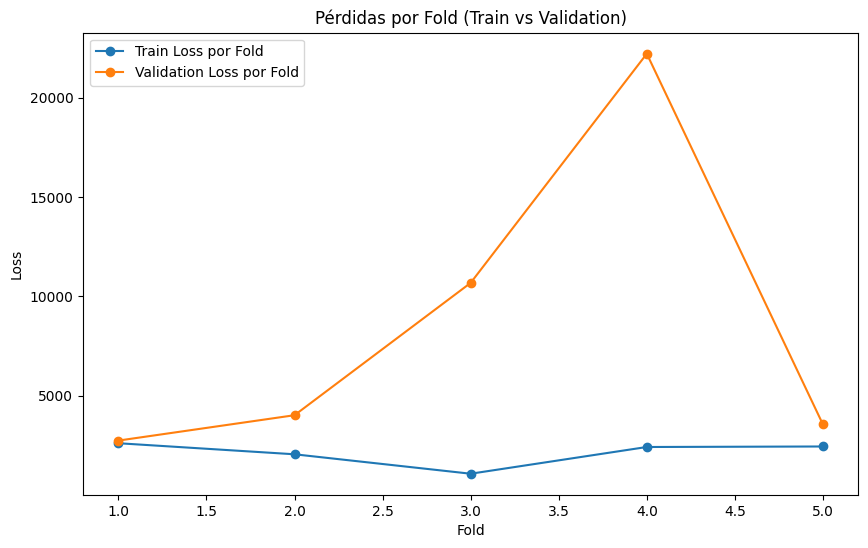

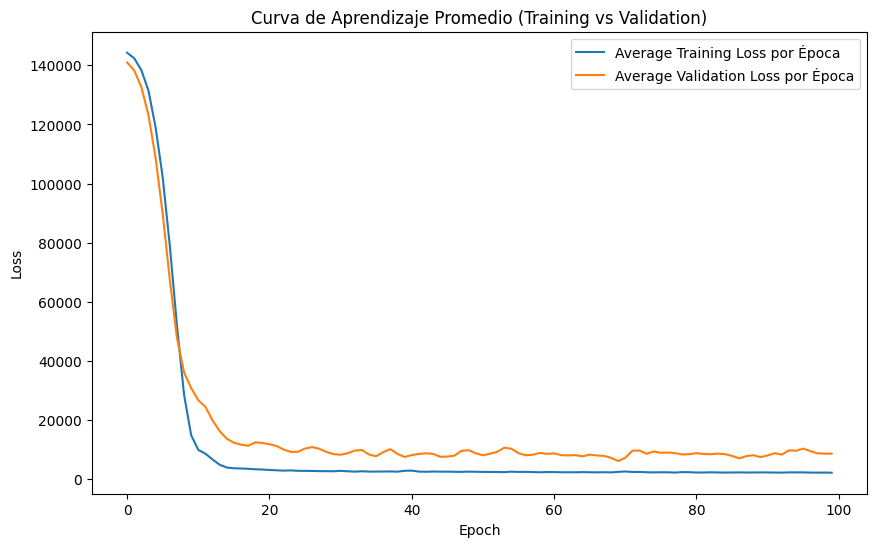

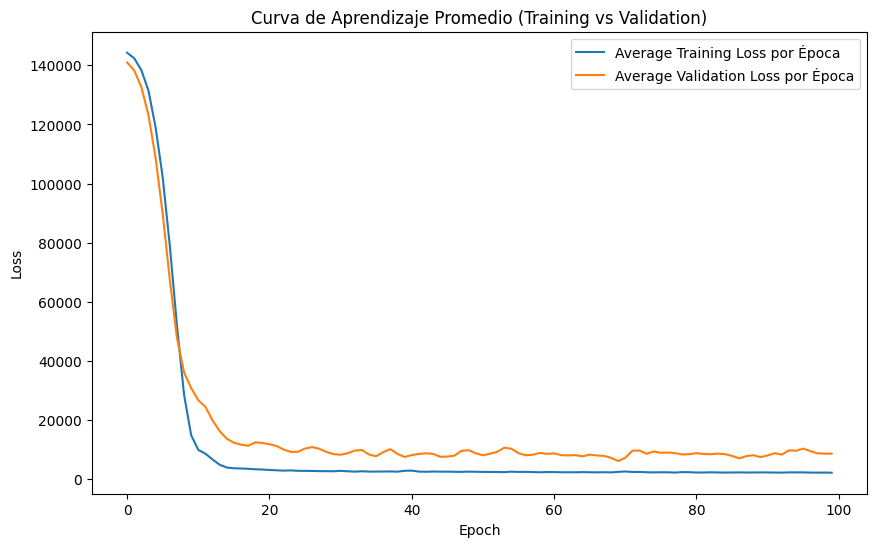

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Definir las entradas y la variable objetivo
X_s = clean_df.drop(['Nombre', 'A', 'Hz', 'S', 'σLOS', 'Rvir', 'Mvir'], axis=1)  # Entradas
y_s = clean_df['S']  # Variable objetivo (Sx)

# Definir el número de pliegos para la validación cruzada
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
val_losses = []
epochs_history = []

# Normalizar los datos
scaler = StandardScaler()

for train_index, val_index in kf.split(X_s):
    # Dividir los datos en conjuntos de entrenamiento y validación en cada pliegue
    X_train, X_val = X_s.iloc[train_index], X_s.iloc[val_index]
    y_train, y_val = y_s.iloc[train_index], y_s.iloc[val_index]

    # Normalizar los datos
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Construir el modelo
    model = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(50, activation='relu'),
        Dense(1, activation='linear'),
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=5, verbose=0,
                        validation_data=(X_val_scaled, y_val))

    # Guardar el historial de épocas para graficar luego
    epochs_history.append(history.history)

    # Evaluar el modelo
    train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
    val_loss = model.evaluate(X_val_scaled, y_val, verbose=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Calcular las pérdidas promedio
average_train_loss = np.mean(train_losses)
average_val_loss = np.mean(val_losses)

print(f"Average Train Loss: {average_train_loss}")
print(f"Average Validation Loss: {average_val_loss}")

### Visualización coherente ###

# Gráfico de pérdidas de cada pliegue
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k + 1), train_losses, label='Train Loss por Fold', marker='o')
plt.plot(np.arange(1, k + 1), val_losses, label='Validation Loss por Fold', marker='o')
plt.title('Pérdidas por Fold (Train vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.legend()
plt.show()

# Gráfico de la curva de aprendizaje promedio
plt.figure(figsize=(10, 6))

# Promediar las curvas de pérdida por época para todos los pliegues
avg_loss_per_epoch = np.mean([h['loss'] for h in epochs_history], axis=0)
avg_val_loss_per_epoch = np.mean([h['val_loss'] for h in epochs_history], axis=0)

plt.plot(avg_loss_per_epoch, label='Average Training Loss por Época')
plt.plot(avg_val_loss_per_epoch, label='Average Validation Loss por Época')

plt.title('Curva de Aprendizaje Promedio (Training vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Gráfico de la curva de aprendizaje promedio
plt.figure(figsize=(10, 6))

# Promediar las curvas de pérdida por época para todos los pliegues
avg_loss_per_epoch = np.mean([h['loss'] for h in epochs_history], axis=0)
avg_val_loss_per_epoch = np.mean([h['val_loss'] for h in epochs_history], axis=0)

plt.plot(avg_loss_per_epoch, label='Average Training Loss por Época')
plt.plot(avg_val_loss_per_epoch, label='Average Validation Loss por Época')

plt.title('Curva de Aprendizaje Promedio (Training vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Fold - Mean Squared Error: 2910.647625209298
Fold - Root Mean Squared Error: 53.95041821162555
Fold - R-squared: 0.9428400046028604


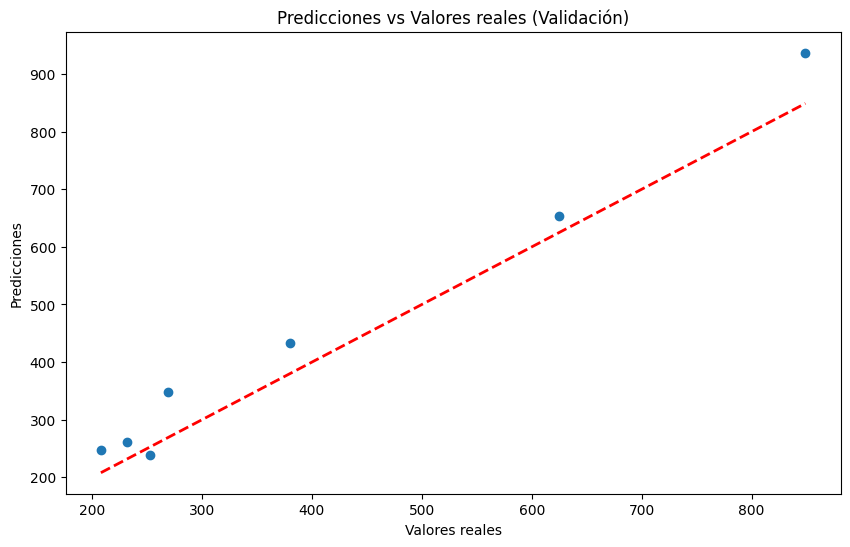

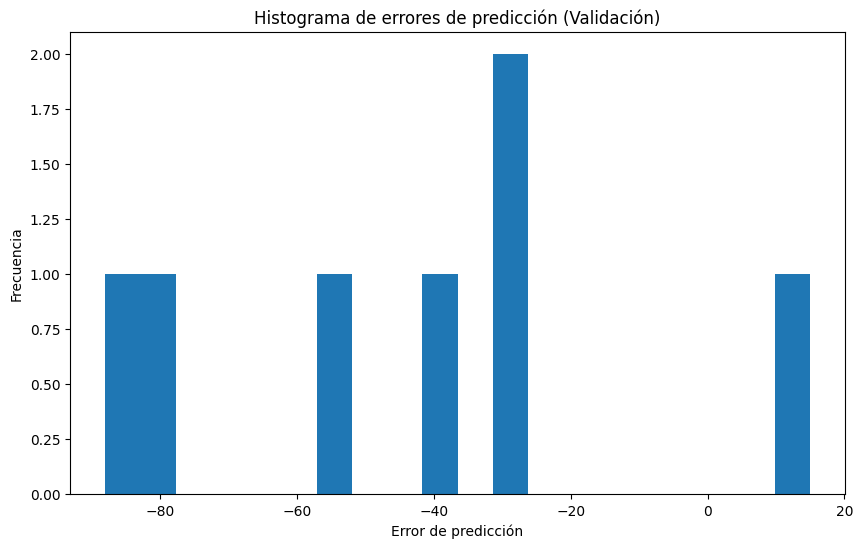

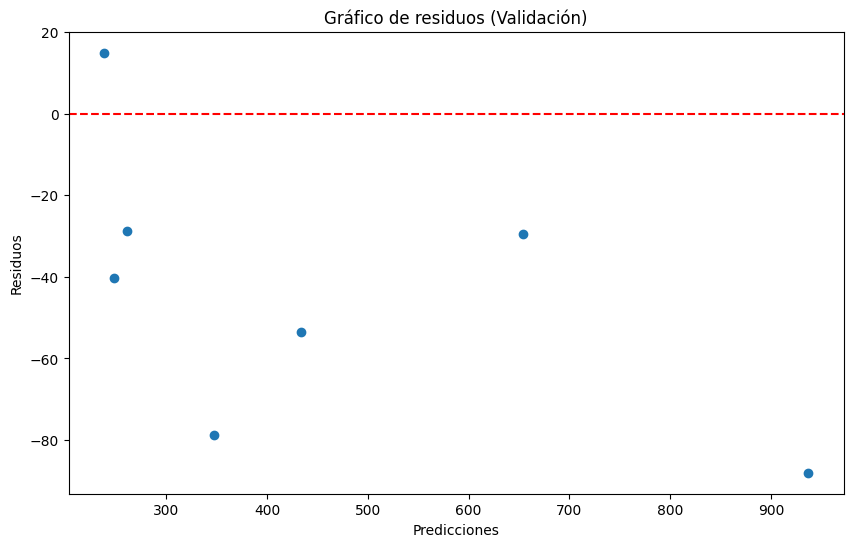

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Fold - Mean Squared Error: 3808.5941457869817
Fold - Root Mean Squared Error: 61.71380838829331
Fold - R-squared: 0.9118019326029561


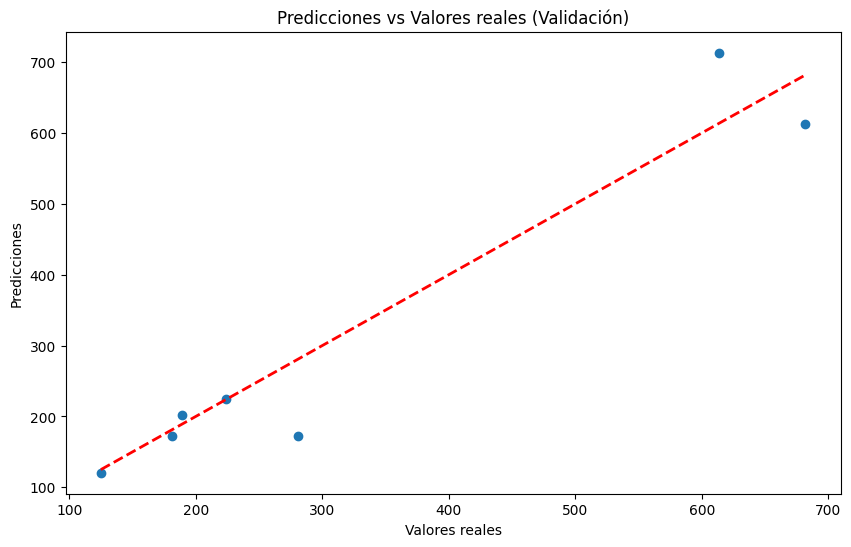

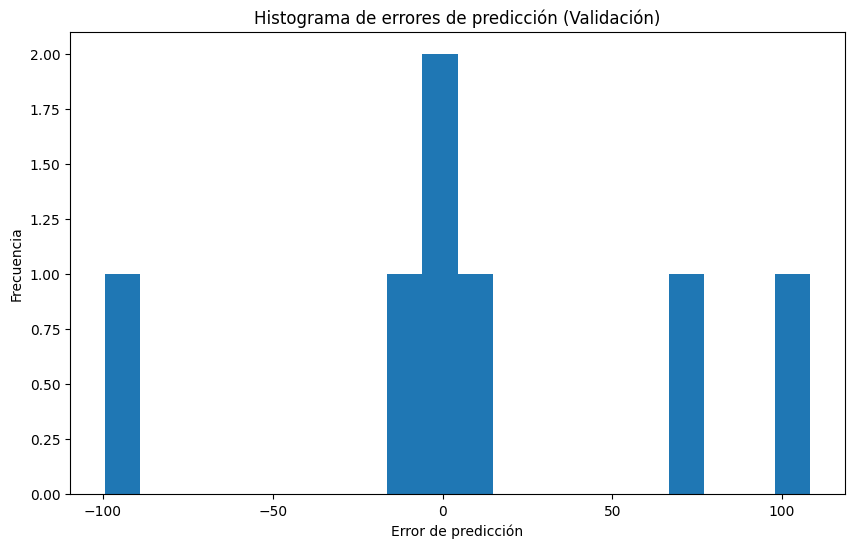

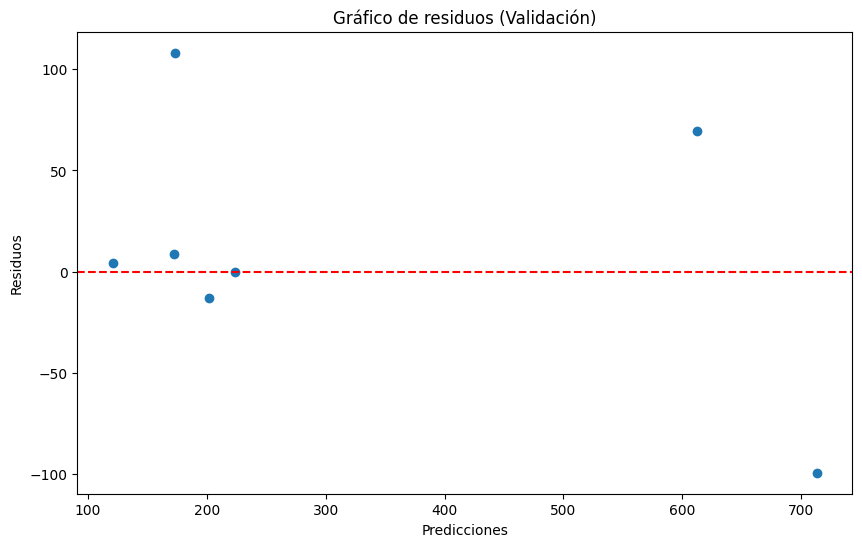

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Fold - Mean Squared Error: 11942.784997530436
Fold - Root Mean Squared Error: 109.28304990953737
Fold - R-squared: 0.7142086235165228


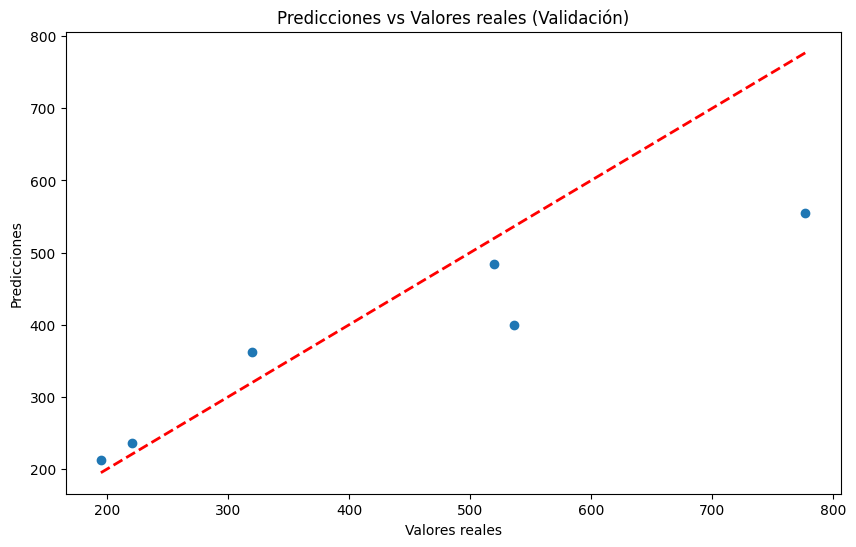

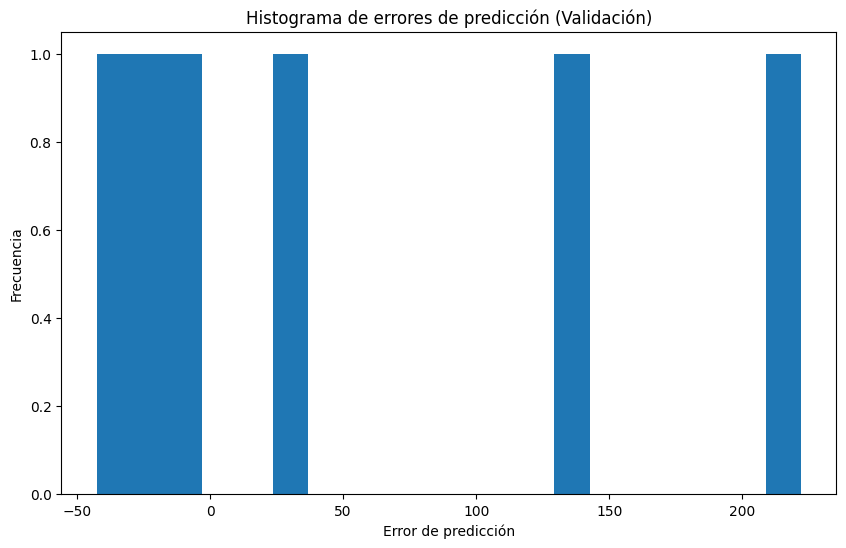

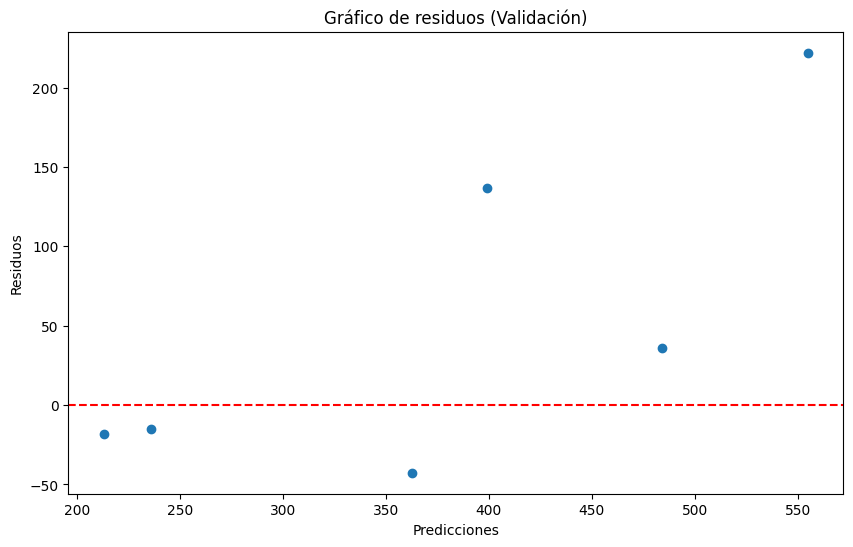

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Fold - Mean Squared Error: 11792.101740725688
Fold - Root Mean Squared Error: 108.59144414145015
Fold - R-squared: -0.3927862001670783


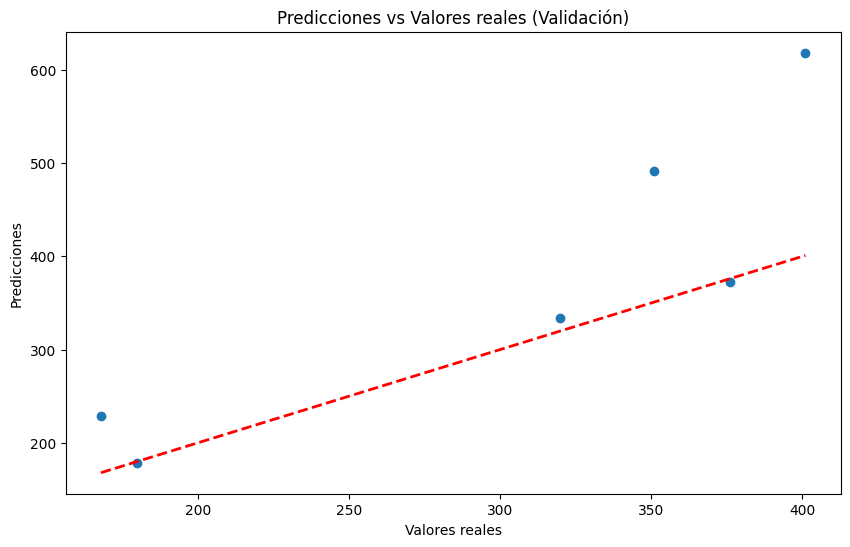

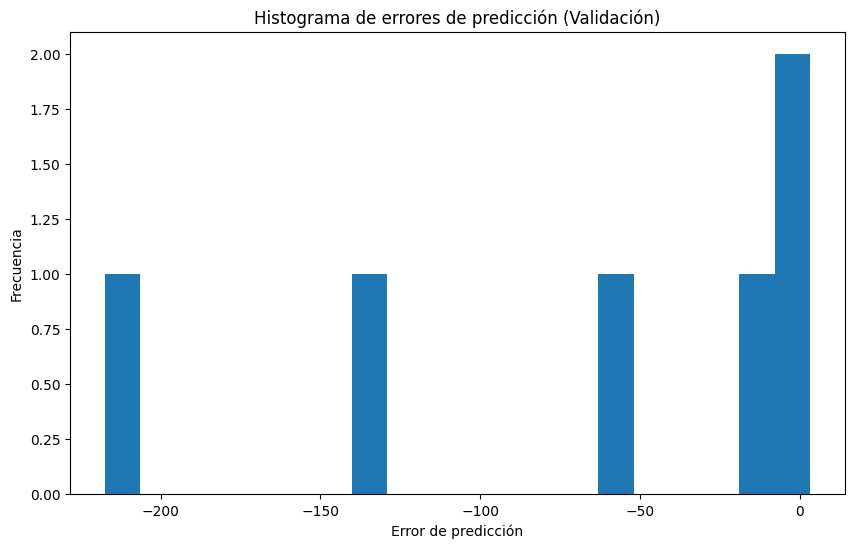

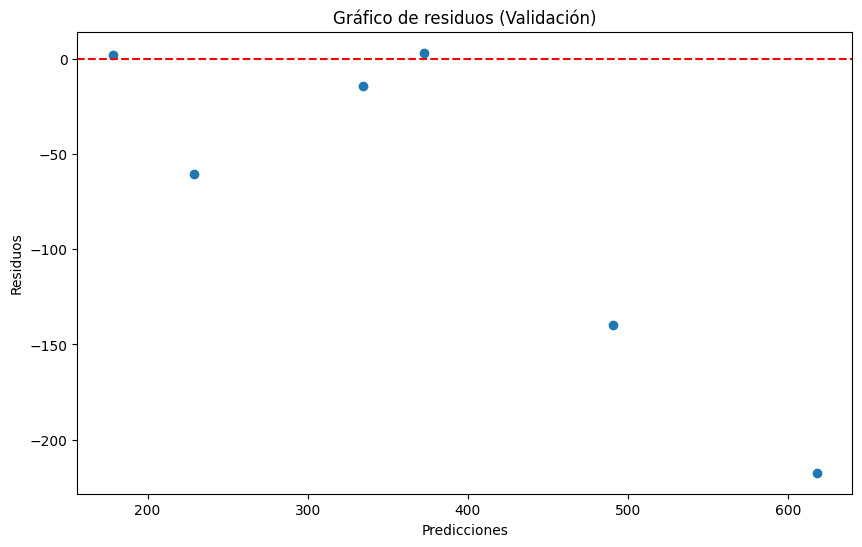

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Fold - Mean Squared Error: 3948.2735391810825
Fold - Root Mean Squared Error: 62.83528896393397
Fold - R-squared: -1.4629481733467506


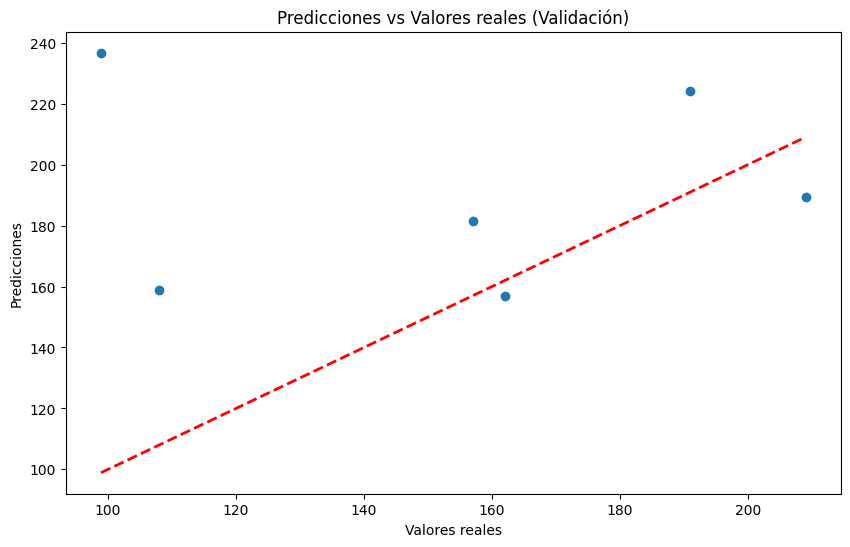

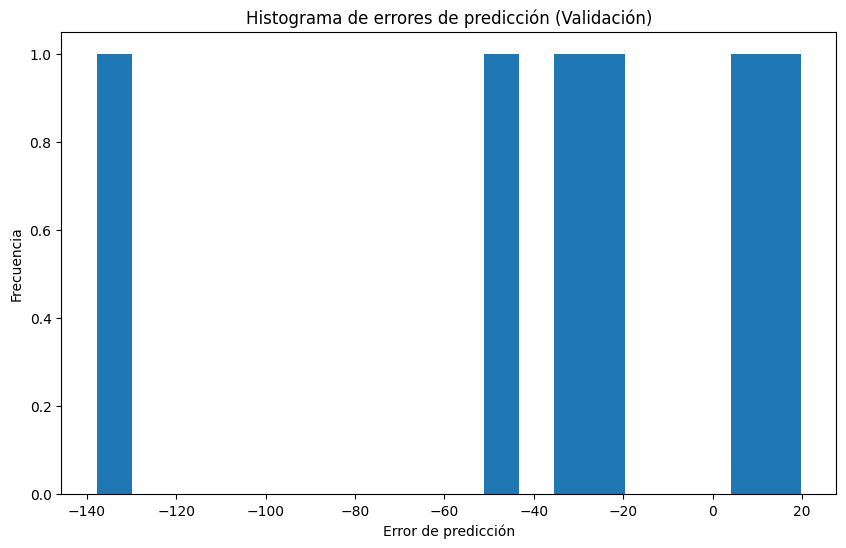

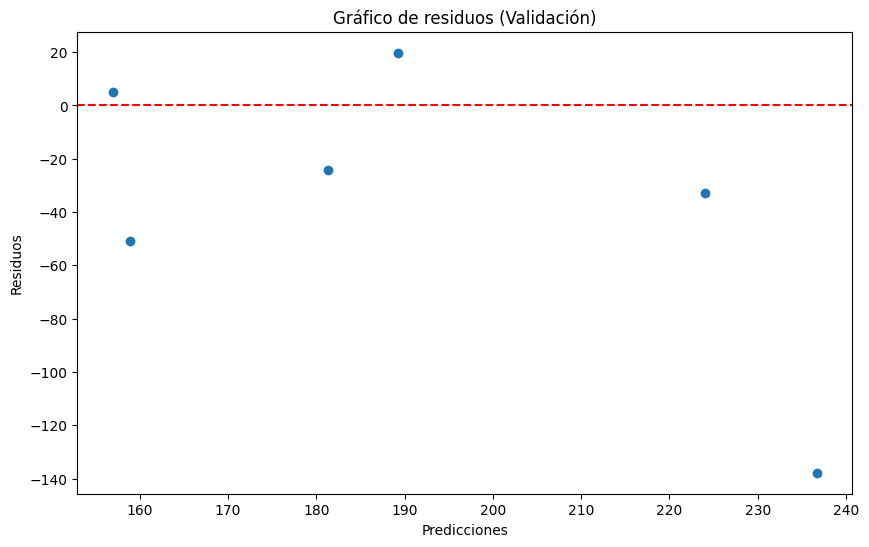

Average Mean Squared Error: 6880.480409686698
Average Root Mean Squared Error: 79.27480192296807
Average R-squared: 0.14262323744170197


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Definir las entradas y la variable objetivo
X_s = clean_df.drop(['Nombre', 'A', 'Hz', 'S', 'σLOS', 'Rvir', 'Mvir'], axis=1)  # Entradas
y_s = clean_df['S']  # Variable objetivo (Sx)

# Definir el número de pliegos para la validación cruzada
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
val_losses = []
epochs_history = []
mse_values = []
rmse_values = []
r2_values = []

# Normalizar los datos
scaler = StandardScaler()

# Validación cruzada
for train_index, val_index in kf.split(X_s):
    X_train, X_val = X_s.iloc[train_index], X_s.iloc[val_index]
    y_train, y_val = y_s.iloc[train_index], y_s.iloc[val_index]

    # Normalizar los datos
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Construir el modelo
    model = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(50, activation='relu'),
        Dense(1, activation='linear'),
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=5, verbose=0,
                        validation_data=(X_val_scaled, y_val))

    # Guardar el historial de épocas para graficar luego
    epochs_history.append(history.history)

    # Evaluar el modelo
    train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
    val_loss = model.evaluate(X_val_scaled, y_val, verbose=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Hacer predicciones en el conjunto de validación
    y_val_pred = model.predict(X_val_scaled)

    # Calcular métricas de evaluación
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_val_pred)

    mse_values.append(mse)
    rmse_values.append(rmse)
    r2_values.append(r2)

    print(f"Fold - Mean Squared Error: {mse}")
    print(f"Fold - Root Mean Squared Error: {rmse}")
    print(f"Fold - R-squared: {r2}")

    ### Gráficos ###

    # Gráfico de predicciones vs valores reales
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('Valores reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Valores reales (Validación)')
    plt.show()

    # Histograma de errores de predicción
    errors = y_val - y_val_pred.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20)
    plt.xlabel('Error de predicción')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de errores de predicción (Validación)')
    plt.show()

    # Gráfico de residuos
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred, errors)
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de residuos (Validación)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

# Calcular las métricas promedio
avg_mse = np.mean(mse_values)
avg_rmse = np.mean(rmse_values)
avg_r2 = np.mean(r2_values)

print(f"Average Mean Squared Error: {avg_mse}")
print(f"Average Root Mean Squared Error: {avg_rmse}")
print(f"Average R-squared: {avg_r2}")


In [ ]:
# Recortar las predicciones y valores reales para que coincidan en tamaño
min_len = min(len(y_s_val), len(y_val_pred))
y_s_val = y_s_val[:min_len]
y_val_pred = y_val_pred[:min_len]

# calcular los errores
errors = y_s_val - y_val_pred.flatten()

# Continuar con el código
validation_results = X_s_val.iloc[:min_len].copy()  # Recortar X_s_val también
validation_results['S'] = y_s_val
validation_results['Predicciones'] = y_val_pred.flatten()
validation_results['Errores'] = errors

# Mostrar cúmulos con errores significativos
threshold = 0.5  # Define un umbral que consideres significativo
significant_errors = validation_results[abs(validation_results['Errores']) > threshold]
print(significant_errors[['S', 'Predicciones', 'Errores']])


        S  Predicciones     Errores
34  380.0    181.366623  198.633377
19  269.0    156.935715  112.064285
29  253.0    189.223602   63.776398
21  849.0    236.713287  612.286713
10  625.0    158.944839  466.055161
12  232.0    224.034485    7.965515


In [ ]:
print(f"Dimensión de y_s_val: {y_s_val.shape}")
print(f"Dimensión de y_val_pred: {y_val_pred.shape}")


Dimensión de y_s_val: (7,)
Dimensión de y_val_pred: (6, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Average Train Loss: 731.5812438964844
Average Validation Loss: 4436.630187988281


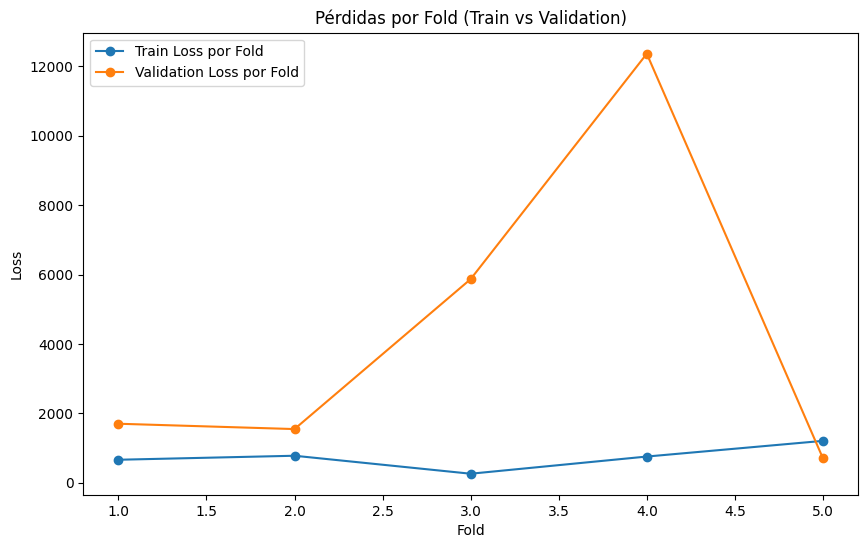

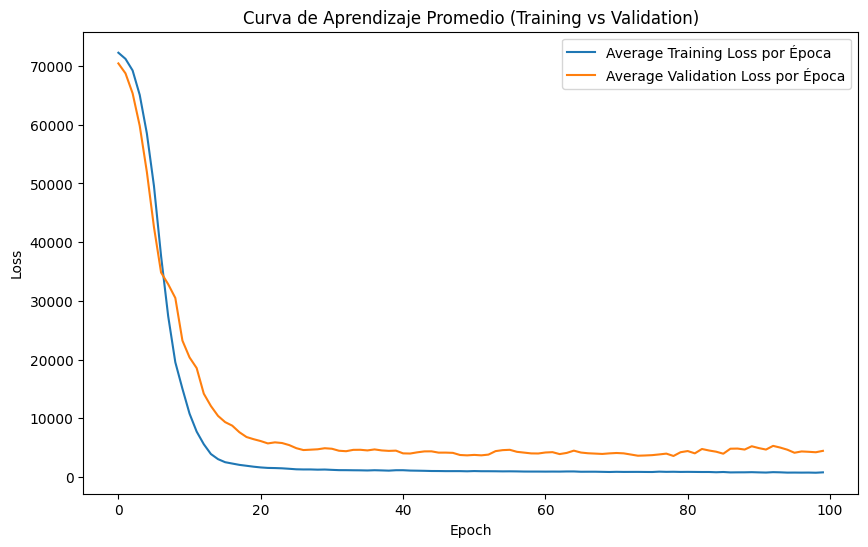

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Preparar los datos
# Entradas: Todos los datos excepto 'S' y 'Hz'
X = clean_df.drop(['Nombre', 'A', 'S', 'Hz'], axis=1)

# Salida: 'S' y 'Hz'
y = clean_df[['S', 'Hz']]

# Definir el número de pliegos para la validación cruzada
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

train_losses = []
val_losses = []
epochs_history = []

# Normalizar los datos
scaler = StandardScaler()

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Normalizar los datos
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Construir el modelo para predecir 2 salidas (S y Hz)
    model = Sequential([
        Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(50, activation='relu'),
        Dense(2, activation='linear'),  # Predicción de dos salidas: S y Hz
    ])

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=5, verbose=0,
                        validation_data=(X_val_scaled, y_val))

    # Guardar el historial de épocas para graficar luego
    epochs_history.append(history.history)

    # Evaluar el modelo
    train_loss = model.evaluate(X_train_scaled, y_train, verbose=0)
    val_loss = model.evaluate(X_val_scaled, y_val, verbose=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Calcular las pérdidas promedio
average_train_loss = np.mean(train_losses)
average_val_loss = np.mean(val_losses)

print(f"Average Train Loss: {average_train_loss}")
print(f"Average Validation Loss: {average_val_loss}")

# Gráfico de pérdidas de cada pliegue
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, k + 1), train_losses, label='Train Loss por Fold', marker='o')
plt.plot(np.arange(1, k + 1), val_losses, label='Validation Loss por Fold', marker='o')
plt.title('Pérdidas por Fold (Train vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.legend()
plt.show()

# Gráfico de la curva de aprendizaje promedio
plt.figure(figsize=(10, 6))

# Promediar las curvas de pérdida por época para todos los pliegues
avg_loss_per_epoch = np.mean([h['loss'] for h in epochs_history], axis=0)
avg_val_loss_per_epoch = np.mean([h['val_loss'] for h in epochs_history], axis=0)

plt.plot(avg_loss_per_epoch, label='Average Training Loss por Época')
plt.plot(avg_val_loss_per_epoch, label='Average Validation Loss por Época')

plt.title('Curva de Aprendizaje Promedio (Training vs Validation)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


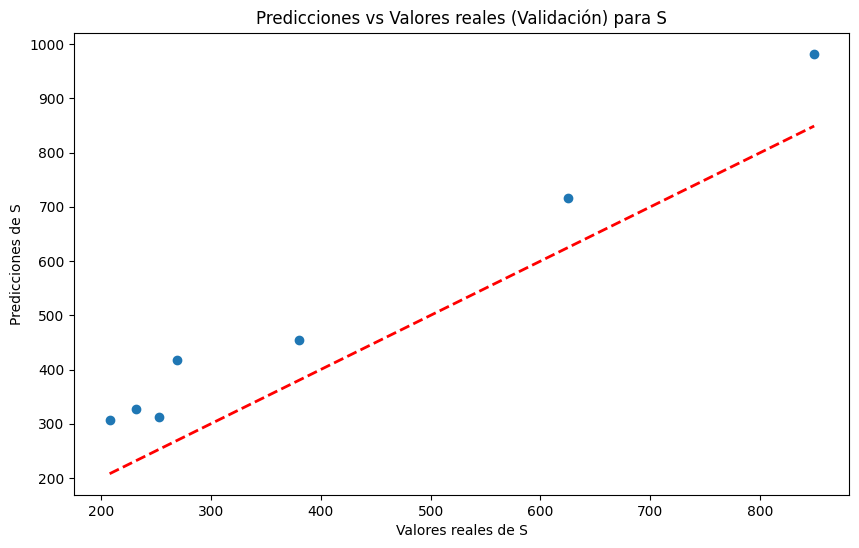

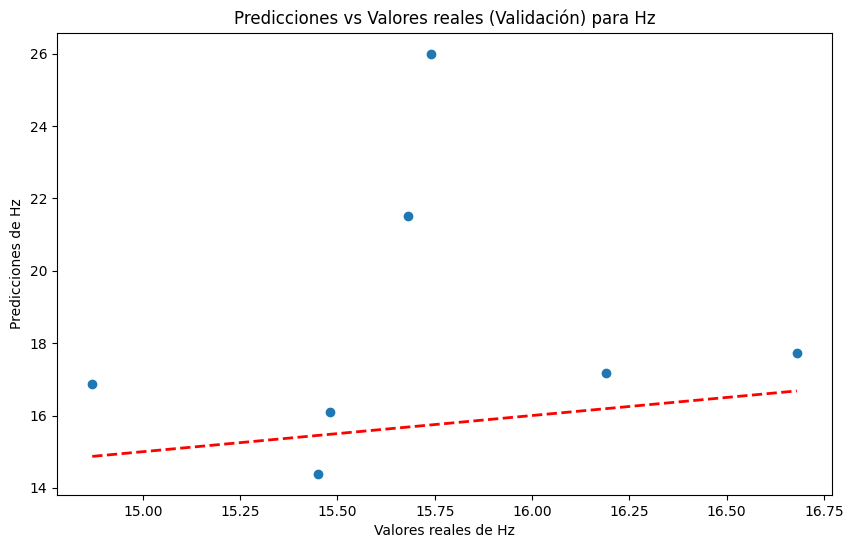

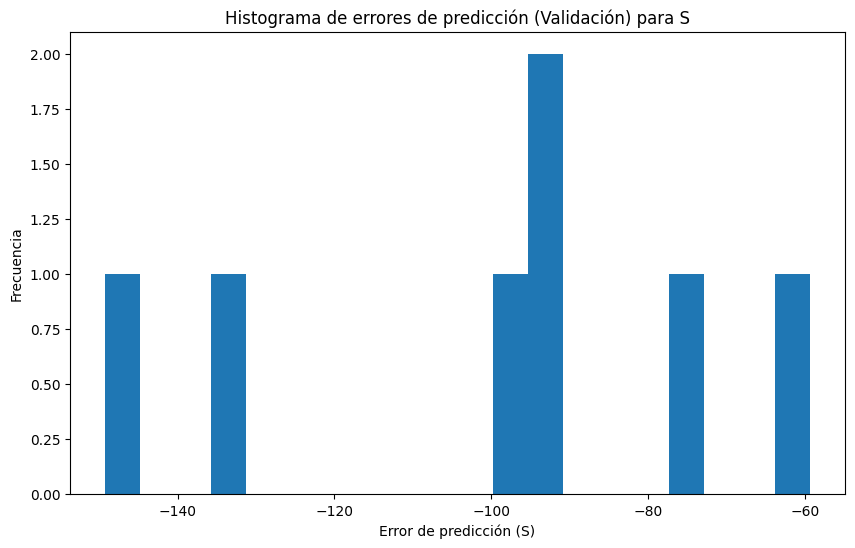

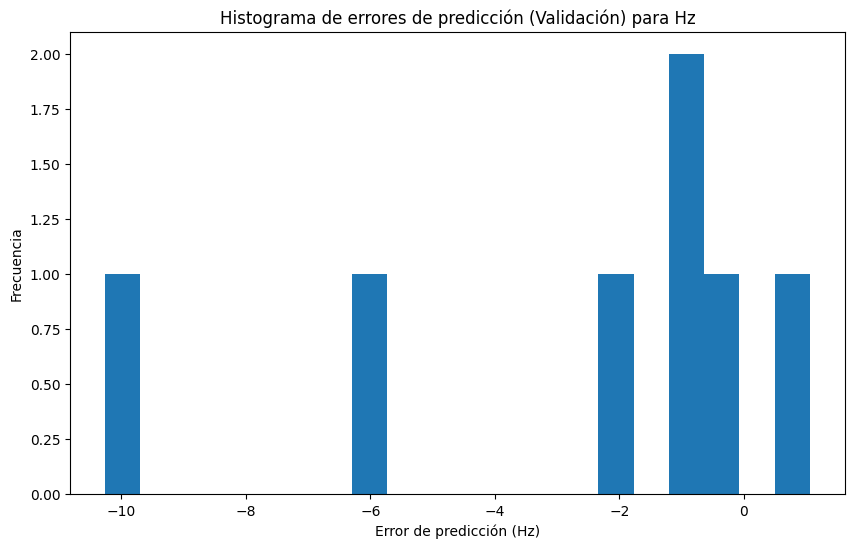

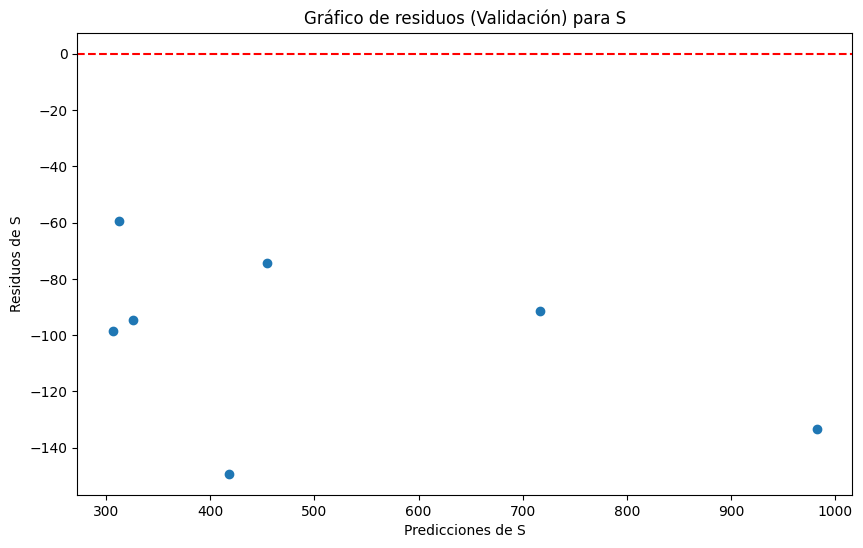

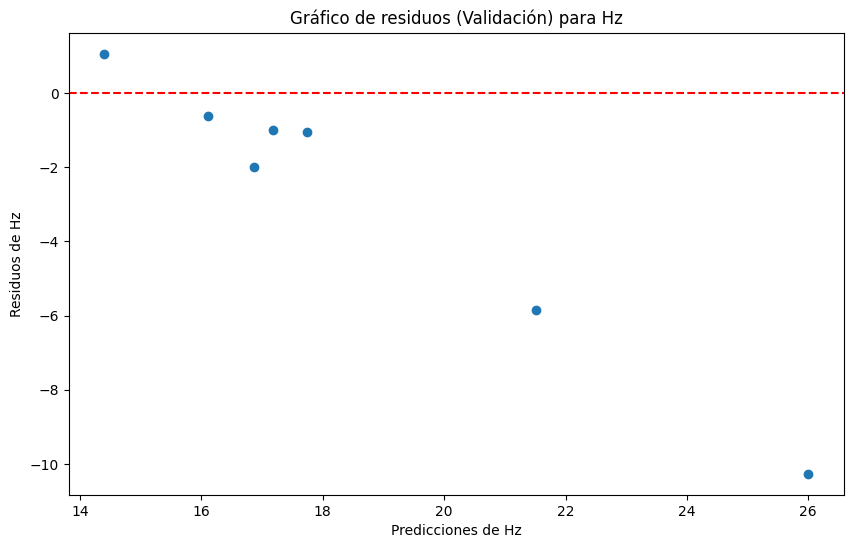

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


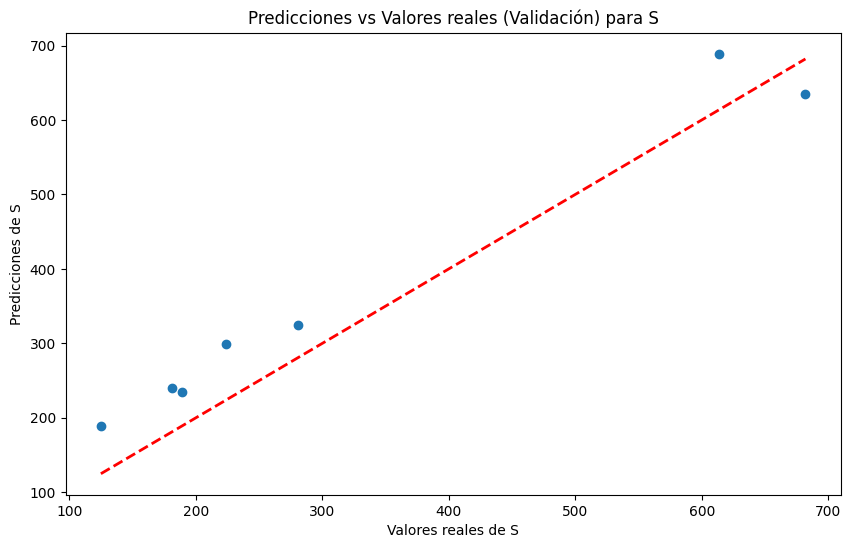

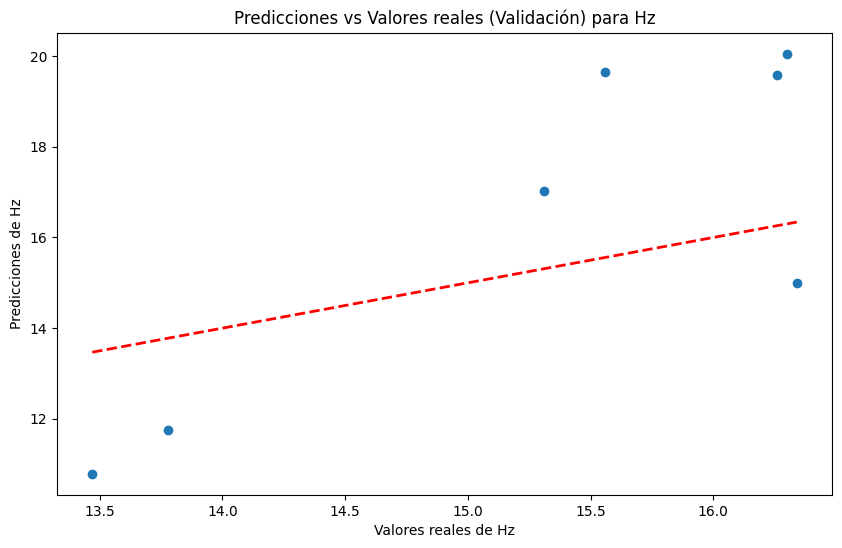

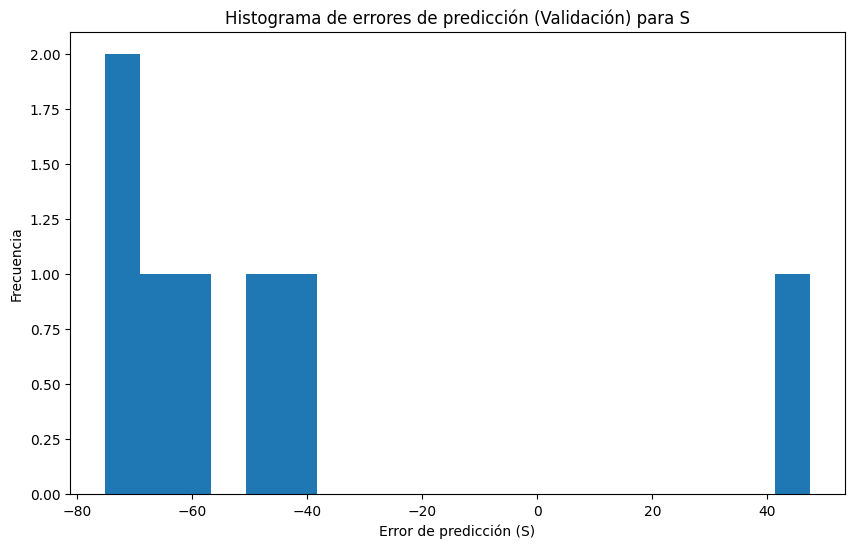

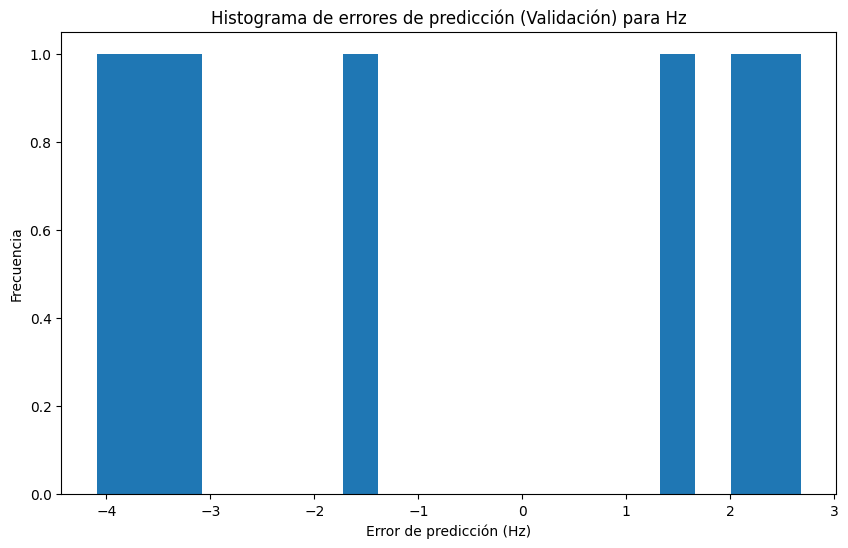

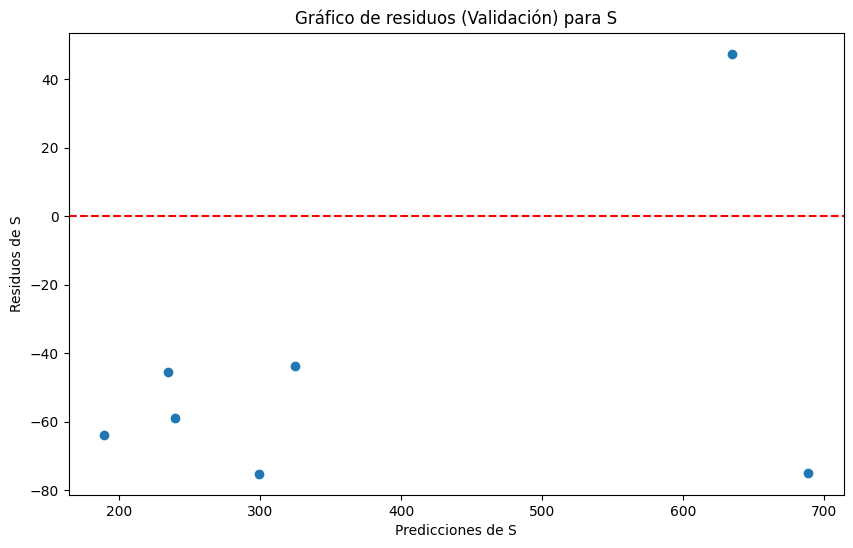

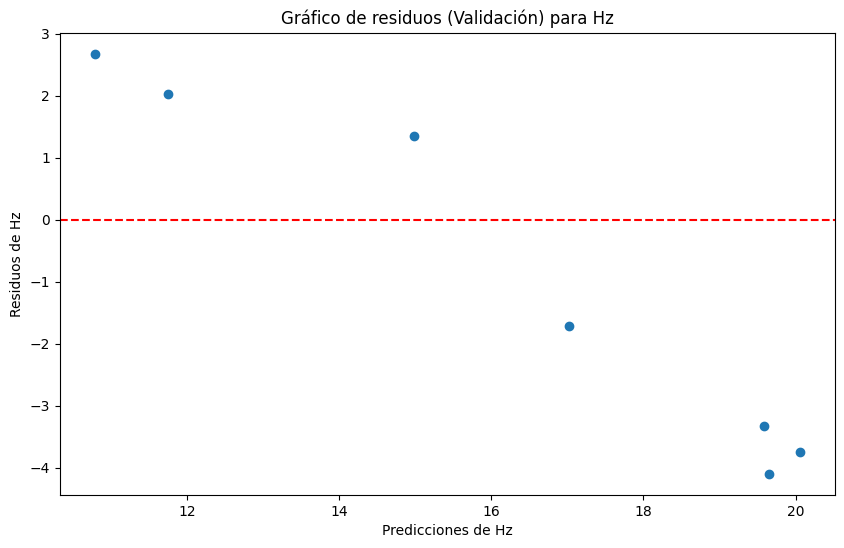

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


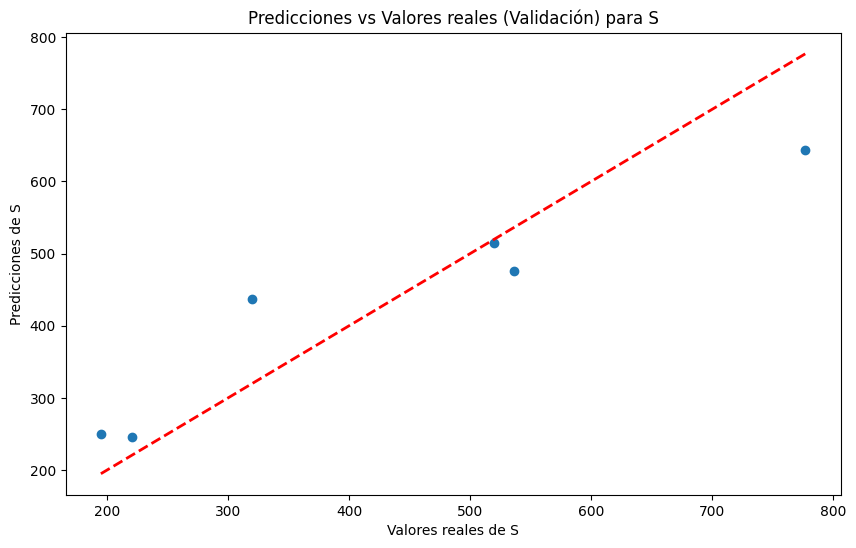

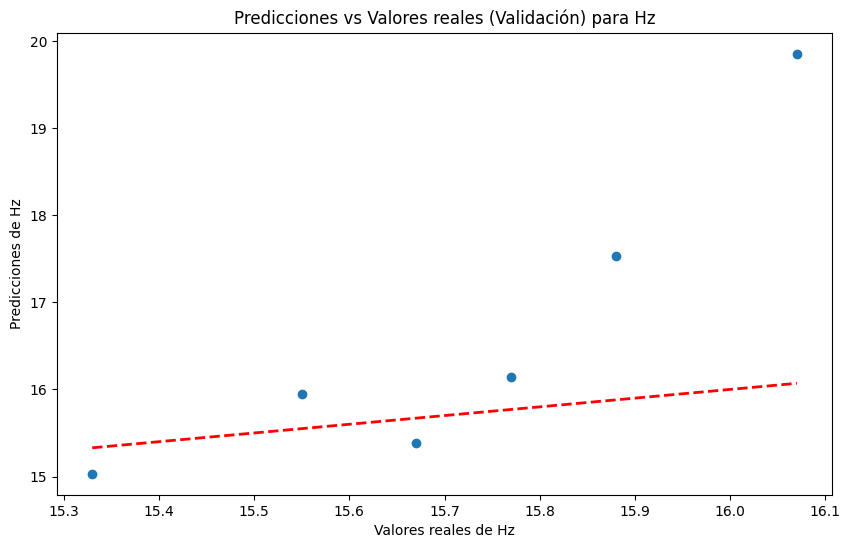

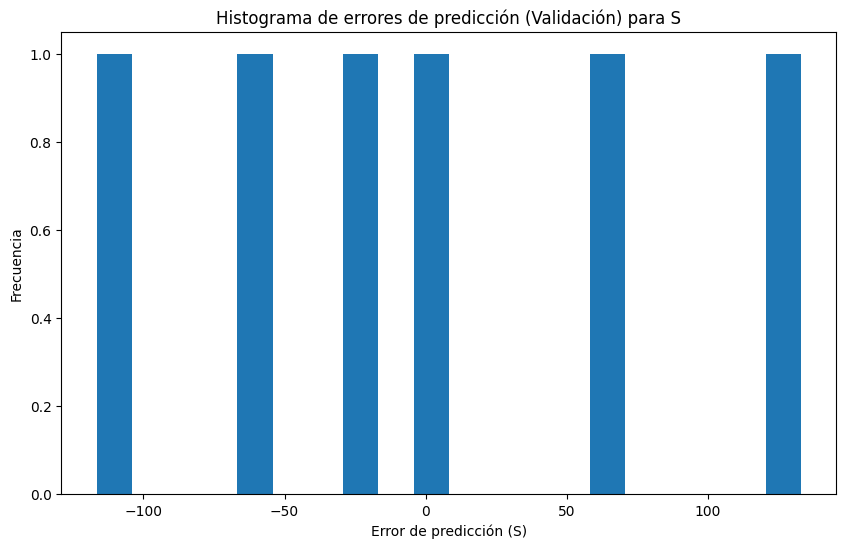

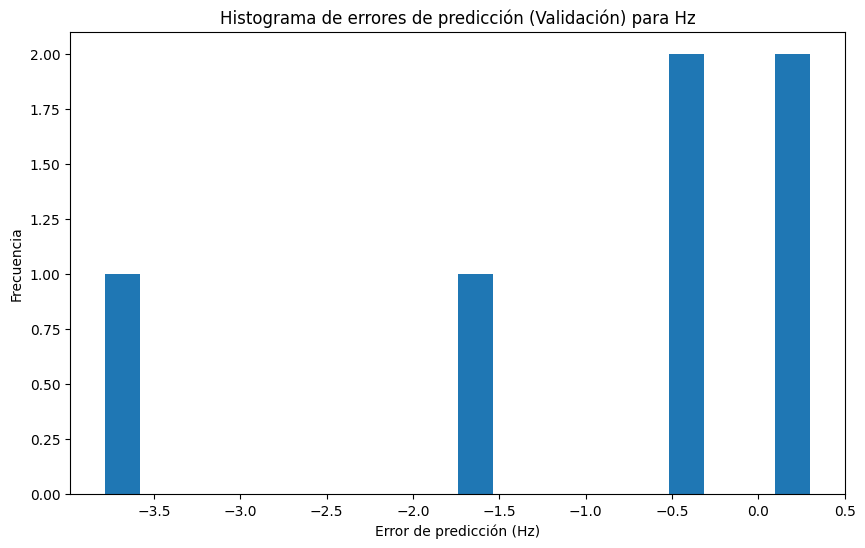

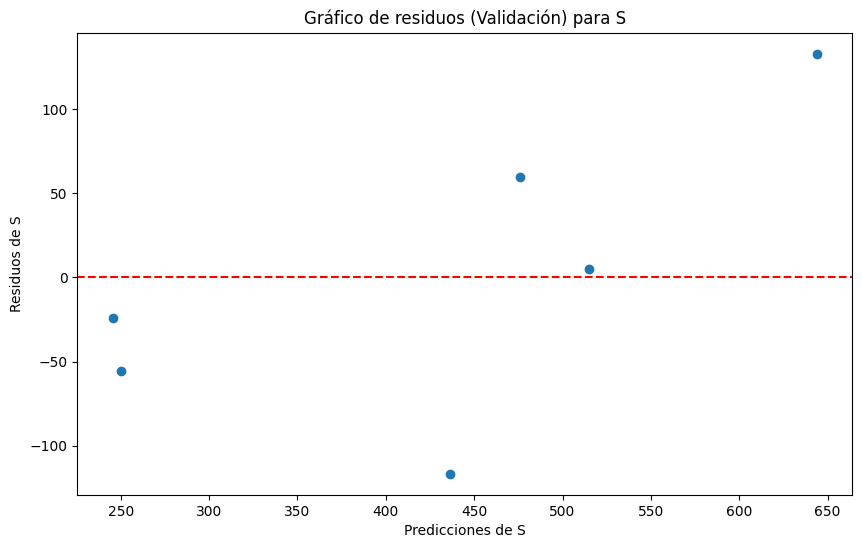

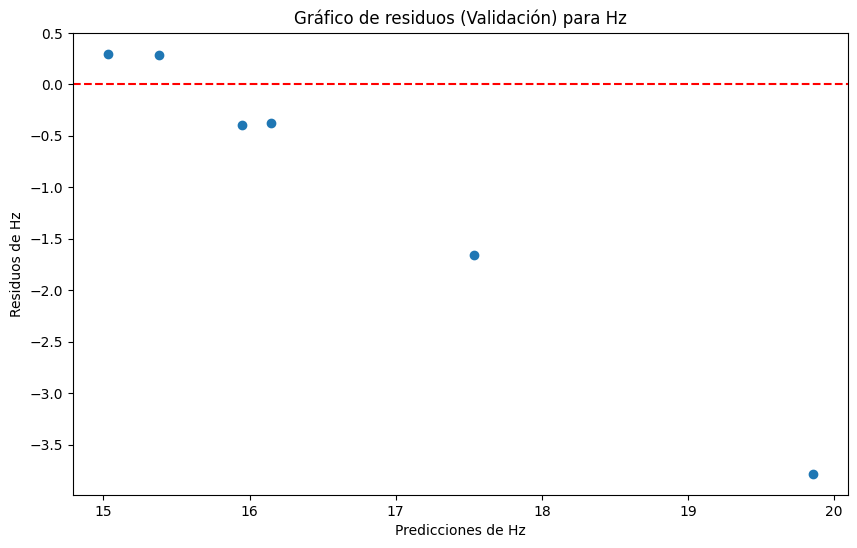

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


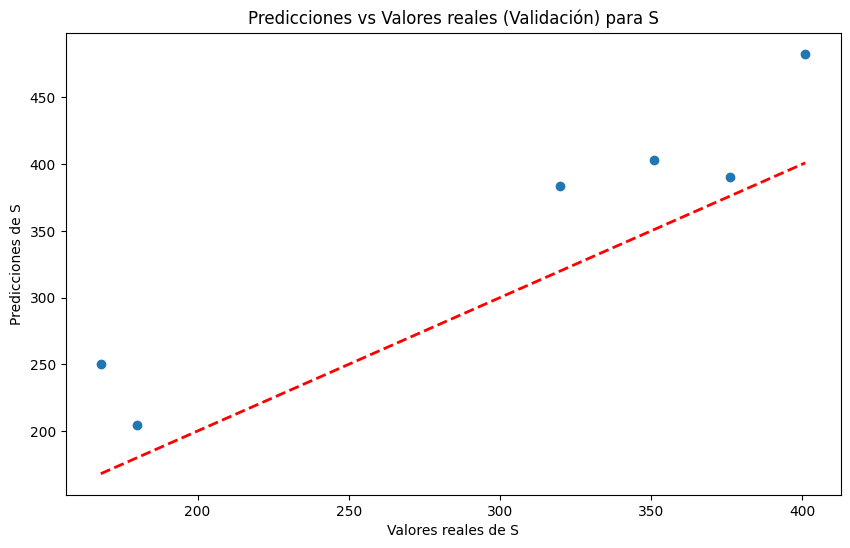

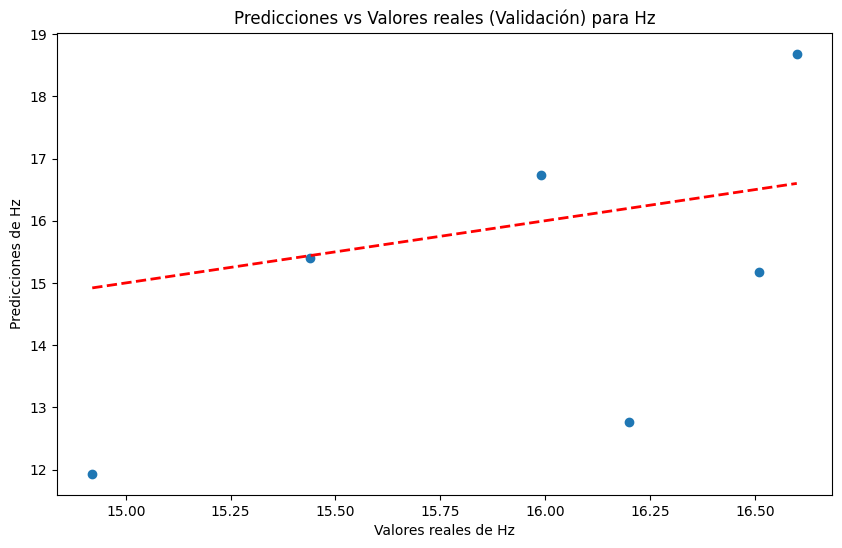

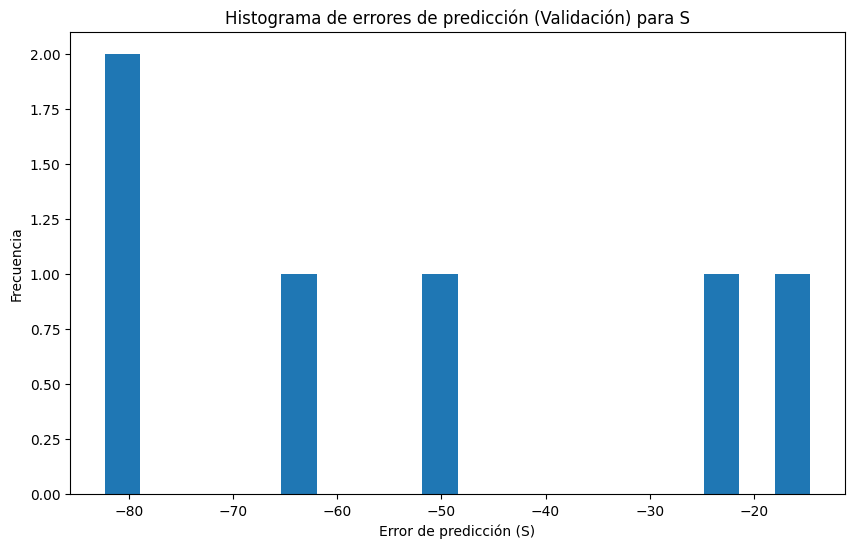

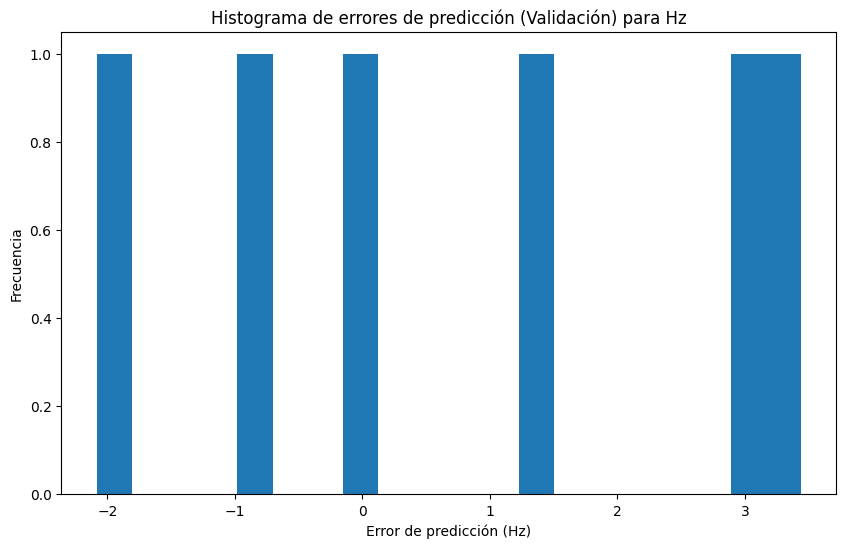

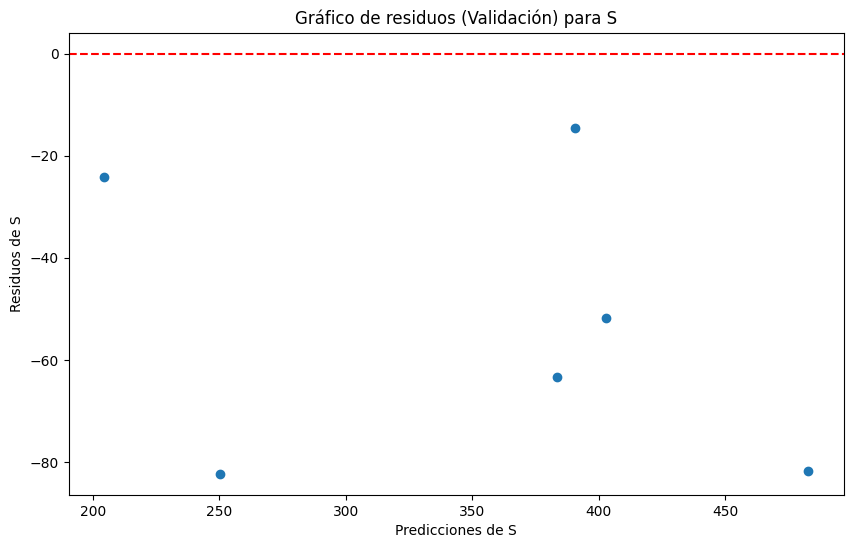

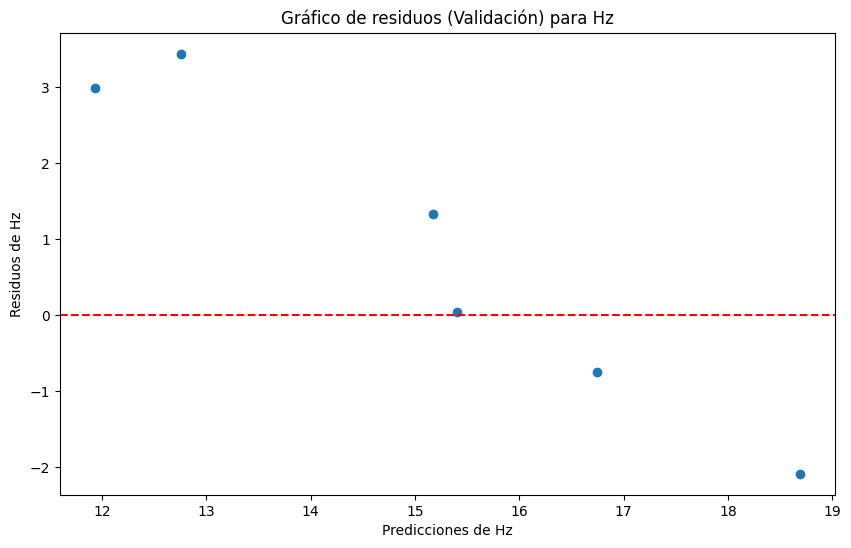

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


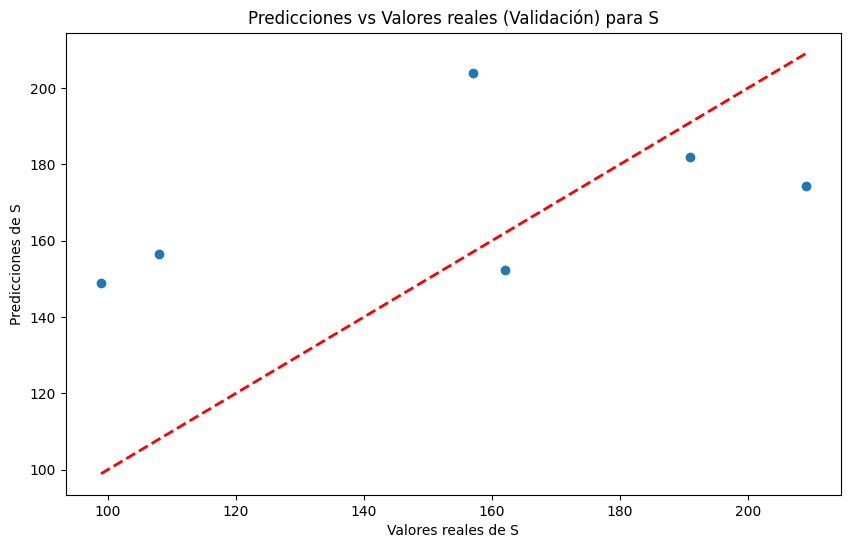

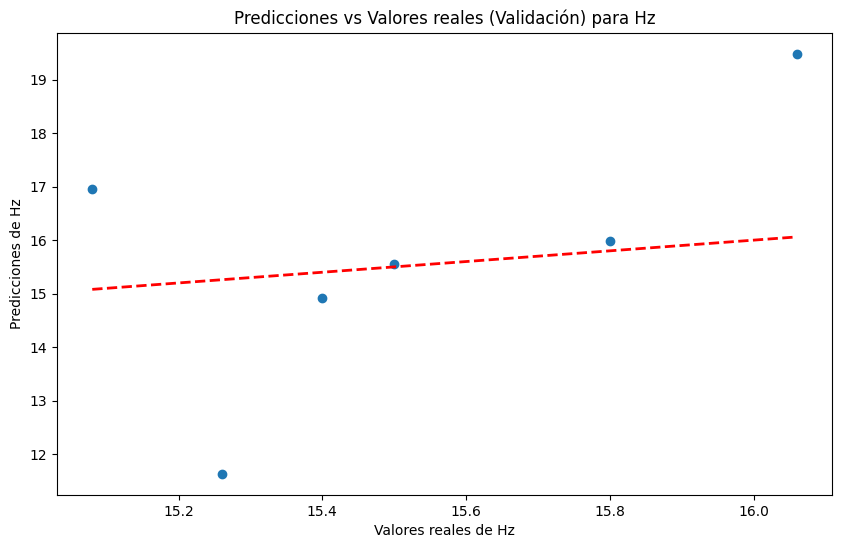

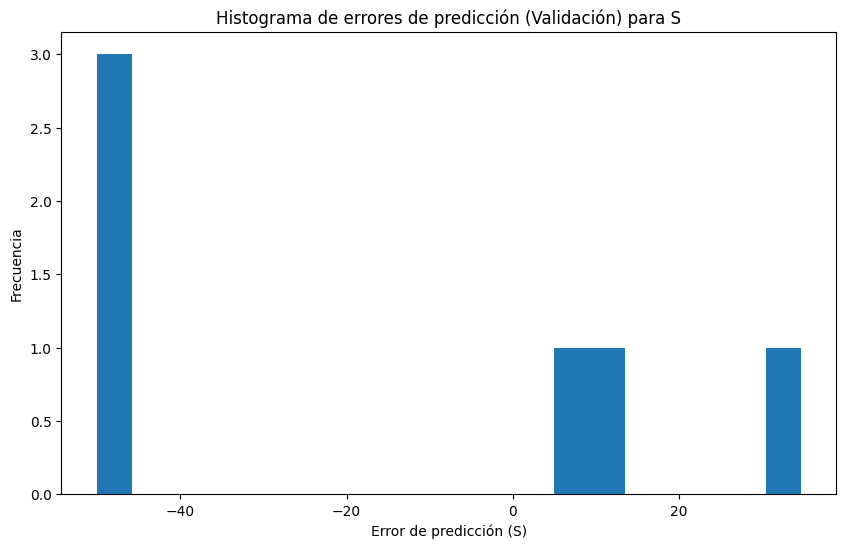

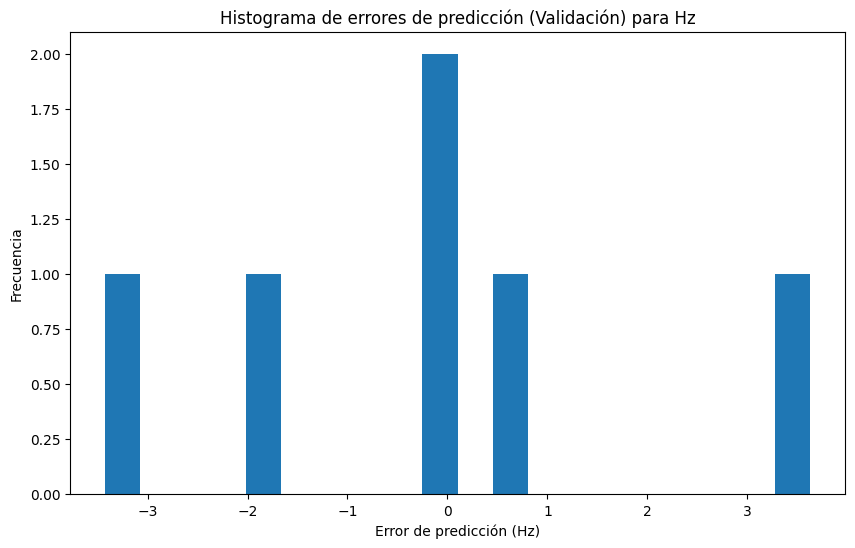

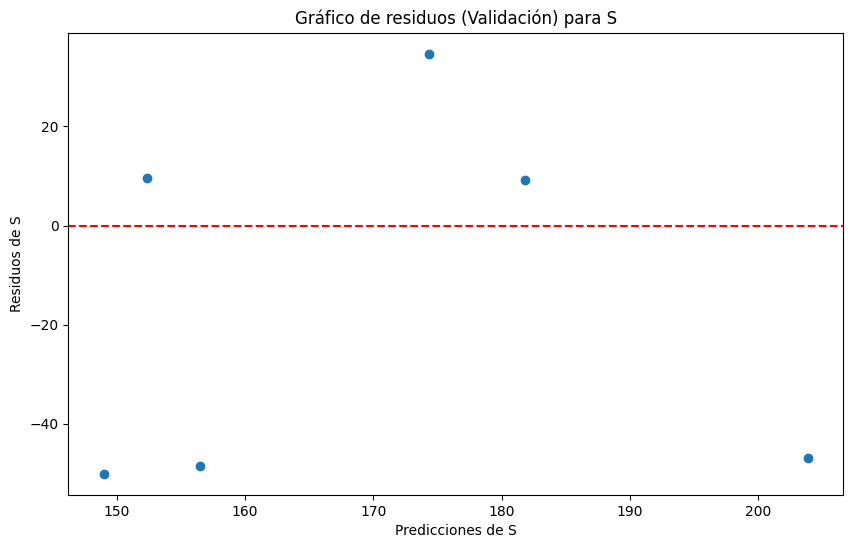

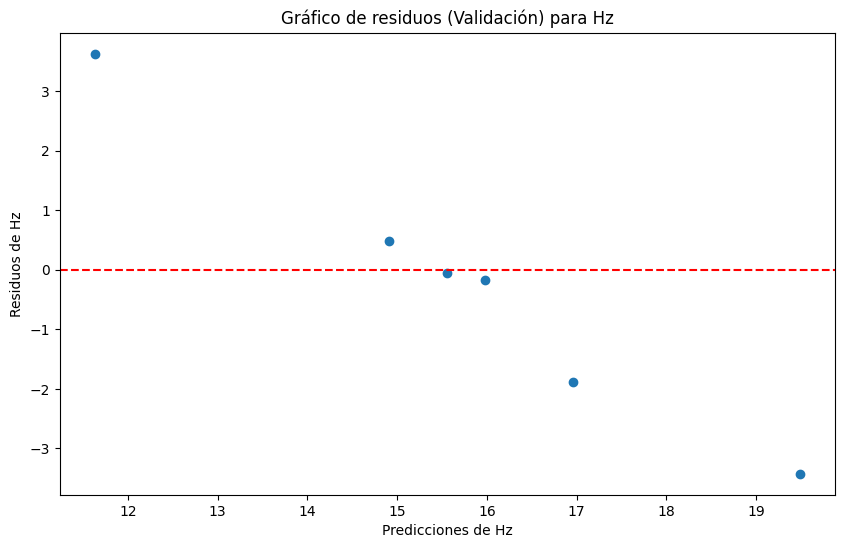

Average Mean Squared Error for S: 5151.892839683985
Average Root Mean Squared Error for S: 68.15234866516332
Average R-squared for S: 0.6521233823279704
Average Mean Squared Error for Hz: 8.309729846307324
Average Root Mean Squared Error for Hz: 2.698699357082025
Average R-squared for Hz: -37.01023804540129


In [ ]:
# Definir listas para almacenar métricas
mse_values_s = []
rmse_values_s = []
r2_values_s = []

mse_values_hz = []
rmse_values_hz = []
r2_values_hz = []

# Validación cruzada ya realizada (continuación)
for train_index, val_index in kf.split(X):
    # Normalización y modelo ya definidos
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Normalizar los datos
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Hacer predicciones en el conjunto de validación
    y_val_pred = model.predict(X_val_scaled)

    # Calcular métricas de evaluación para S
    mse_s = mean_squared_error(y_val['S'], y_val_pred[:, 0])
    rmse_s = np.sqrt(mse_s)
    r2_s = r2_score(y_val['S'], y_val_pred[:, 0])

    mse_values_s.append(mse_s)
    rmse_values_s.append(rmse_s)
    r2_values_s.append(r2_s)

    # Calcular métricas de evaluación para Hz
    mse_hz = mean_squared_error(y_val['Hz'], y_val_pred[:, 1])
    rmse_hz = np.sqrt(mse_hz)
    r2_hz = r2_score(y_val['Hz'], y_val_pred[:, 1])

    mse_values_hz.append(mse_hz)
    rmse_values_hz.append(rmse_hz)
    r2_values_hz.append(r2_hz)

    # Gráfico de predicciones vs valores reales para S
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val['S'], y_val_pred[:, 0], label='S')
    plt.plot([y_val['S'].min(), y_val['S'].max()], [y_val['S'].min(), y_val['S'].max()], 'r--', lw=2)
    plt.xlabel('Valores reales de S')
    plt.ylabel('Predicciones de S')
    plt.title('Predicciones vs Valores reales (Validación) para S')
    plt.show()

    # Gráfico de predicciones vs valores reales para Hz
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val['Hz'], y_val_pred[:, 1], label='Hz')
    plt.plot([y_val['Hz'].min(), y_val['Hz'].max()], [y_val['Hz'].min(), y_val['Hz'].max()], 'r--', lw=2)
    plt.xlabel('Valores reales de Hz')
    plt.ylabel('Predicciones de Hz')
    plt.title('Predicciones vs Valores reales (Validación) para Hz')
    plt.show()

    # Histograma de errores de predicción para S
    errors_s = y_val['S'] - y_val_pred[:, 0]
    plt.figure(figsize=(10, 6))
    plt.hist(errors_s, bins=20)
    plt.xlabel('Error de predicción (S)')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de errores de predicción (Validación) para S')
    plt.show()

    # Histograma de errores de predicción para Hz
    errors_hz = y_val['Hz'] - y_val_pred[:, 1]
    plt.figure(figsize=(10, 6))
    plt.hist(errors_hz, bins=20)
    plt.xlabel('Error de predicción (Hz)')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de errores de predicción (Validación) para Hz')
    plt.show()

    # Gráfico de residuos para S
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred[:, 0], errors_s)
    plt.xlabel('Predicciones de S')
    plt.ylabel('Residuos de S')
    plt.title('Gráfico de residuos (Validación) para S')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

    # Gráfico de residuos para Hz
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred[:, 1], errors_hz)
    plt.xlabel('Predicciones de Hz')
    plt.ylabel('Residuos de Hz')
    plt.title('Gráfico de residuos (Validación) para Hz')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

# Calcular las métricas promedio para S
avg_mse_s = np.mean(mse_values_s)
avg_rmse_s = np.mean(rmse_values_s)
avg_r2_s = np.mean(r2_values_s)

print(f"Average Mean Squared Error for S: {avg_mse_s}")
print(f"Average Root Mean Squared Error for S: {avg_rmse_s}")
print(f"Average R-squared for S: {avg_r2_s}")

# Calcular las métricas promedio para Hz
avg_mse_hz = np.mean(mse_values_hz)
avg_rmse_hz = np.mean(rmse_values_hz)
avg_r2_hz = np.mean(r2_values_hz)

print(f"Average Mean Squared Error for Hz: {avg_mse_hz}")
print(f"Average Root Mean Squared Error for Hz: {avg_rmse_hz}")
print(f"Average R-squared for Hz: {avg_r2_hz}")
